<h1>Neural network Modeling</h1>

In [4]:
import shap
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import yfinance as yf
import torch.optim as optim
#from torchviz import make_dot
from tqdm.notebook import tqdm
from datetime import timedelta
#from torchsummary import summary
from IPython.display import Image
import plotly.graph_objects as go
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from pathlib import Path
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
import tempfile
from functools import partial
import sys

In [5]:
# --- Imports & path setup -------------------------------------------------
import os, sys, math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import Callable

np.random.seed(42); random.seed(42); torch.manual_seed(42)

# Make sure we can import hcr_nn whether we run from repo root or examples/
CWD = os.path.abspath(os.getcwd())
REPO_ROOT = os.path.abspath(os.path.join(CWD, '..')) if os.path.basename(CWD) == 'examples' else CWD
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

from hcr_nn.layers import CDFNorm
from hcr_nn.models import build_hcr_cond2d, HCRCond2D
from hcr_nn.basis import select_basis
from hcr_nn.density import conditional_density, expected_u1_given_u2
from hcr_nn.neuron import HCRNeuron

print('hcr_nn imported. Repo root =', REPO_ROOT)

hcr_nn imported. Repo root = c:\Users\X\Desktop\basically all\HCRNN\HCR-NN-Library\paper_stuffs\poc_stock_market


In [6]:
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [7]:
module_path = os.path.abspath(os.path.join('../hcr_nn/layers.py'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from hcr_nn.layers import *

<H2>Gathering data of CDPR stock tickers</H2>

In [8]:
#skip ticker generation if it's present in the folder. Yahoo sometimes is too heavily occupied and cannot answer
path = './HCR-NN-Library/paper_stuffs/paper_data'

if not os.path.isfile(path):
    tck = yf.Ticker("ETH-USD")
    start_date = "2021-01-01"
    end_date = '2022-01-01'
    df = tck.history(start=start_date, end=end_date)
    df.to_csv('../paper_data/CDPR_stock_data.csv', index=False)
else:
    df = pd.read_csv(path)

In [9]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,13652004358,0.0,0.0
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,19740771179,0.0,0.0
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,45200463368,0.0,0.0
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,56945985763,0.0,0.0
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,41535932781,0.0,0.0


In [92]:
#use only if first block fails for some reason
#df.to_csv('./data/prices/ticker.csv', index=False)

<h2>Drop the dividends and Stock Splits columns. We don't include them in our analysis.</h2>

In [10]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df['Volume'] = df['Volume'].astype('float64')
columns=['Open', 'High', 'Low', 'Close', 'Volume']
df.columns == columns

array([ True,  True,  True,  True,  True])

<h2>Plot to check for missing data</h2>

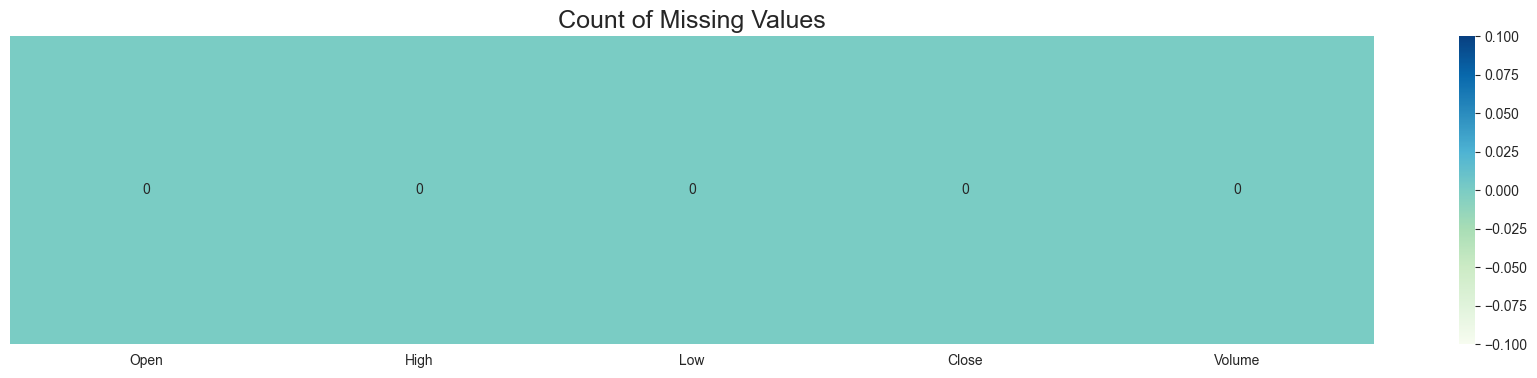

In [94]:
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
plt.show()

In [95]:
df.describe().T.style.background_gradient(cmap='GnBu', axis=1)

,count,mean,std,min,25%,50%,75%,max
Open,365.000000,2771.215477,1029.448767,730.402649,1886.667603,2629.748779,3632.219727,4810.071289
High,365.000000,2872.125942,1048.947824,749.201843,1959.696289,2750.534912,3827.981934,4891.704590
Low,365.000000,2658.899019,1004.316330,718.109497,1811.245850,2485.375000,3544.640381,4718.039062
Close,365.000000,2778.354149,1023.543690,730.367554,1895.552124,2633.518311,3638.122070,4812.087402
Volume,365.000000,27280819104.775341,11663121397.180578,10894785525.000000,18991302378.000000,23868866254.000000,32275969215.000000,84482912776.000000


<h2>Visualizing data.</h2>

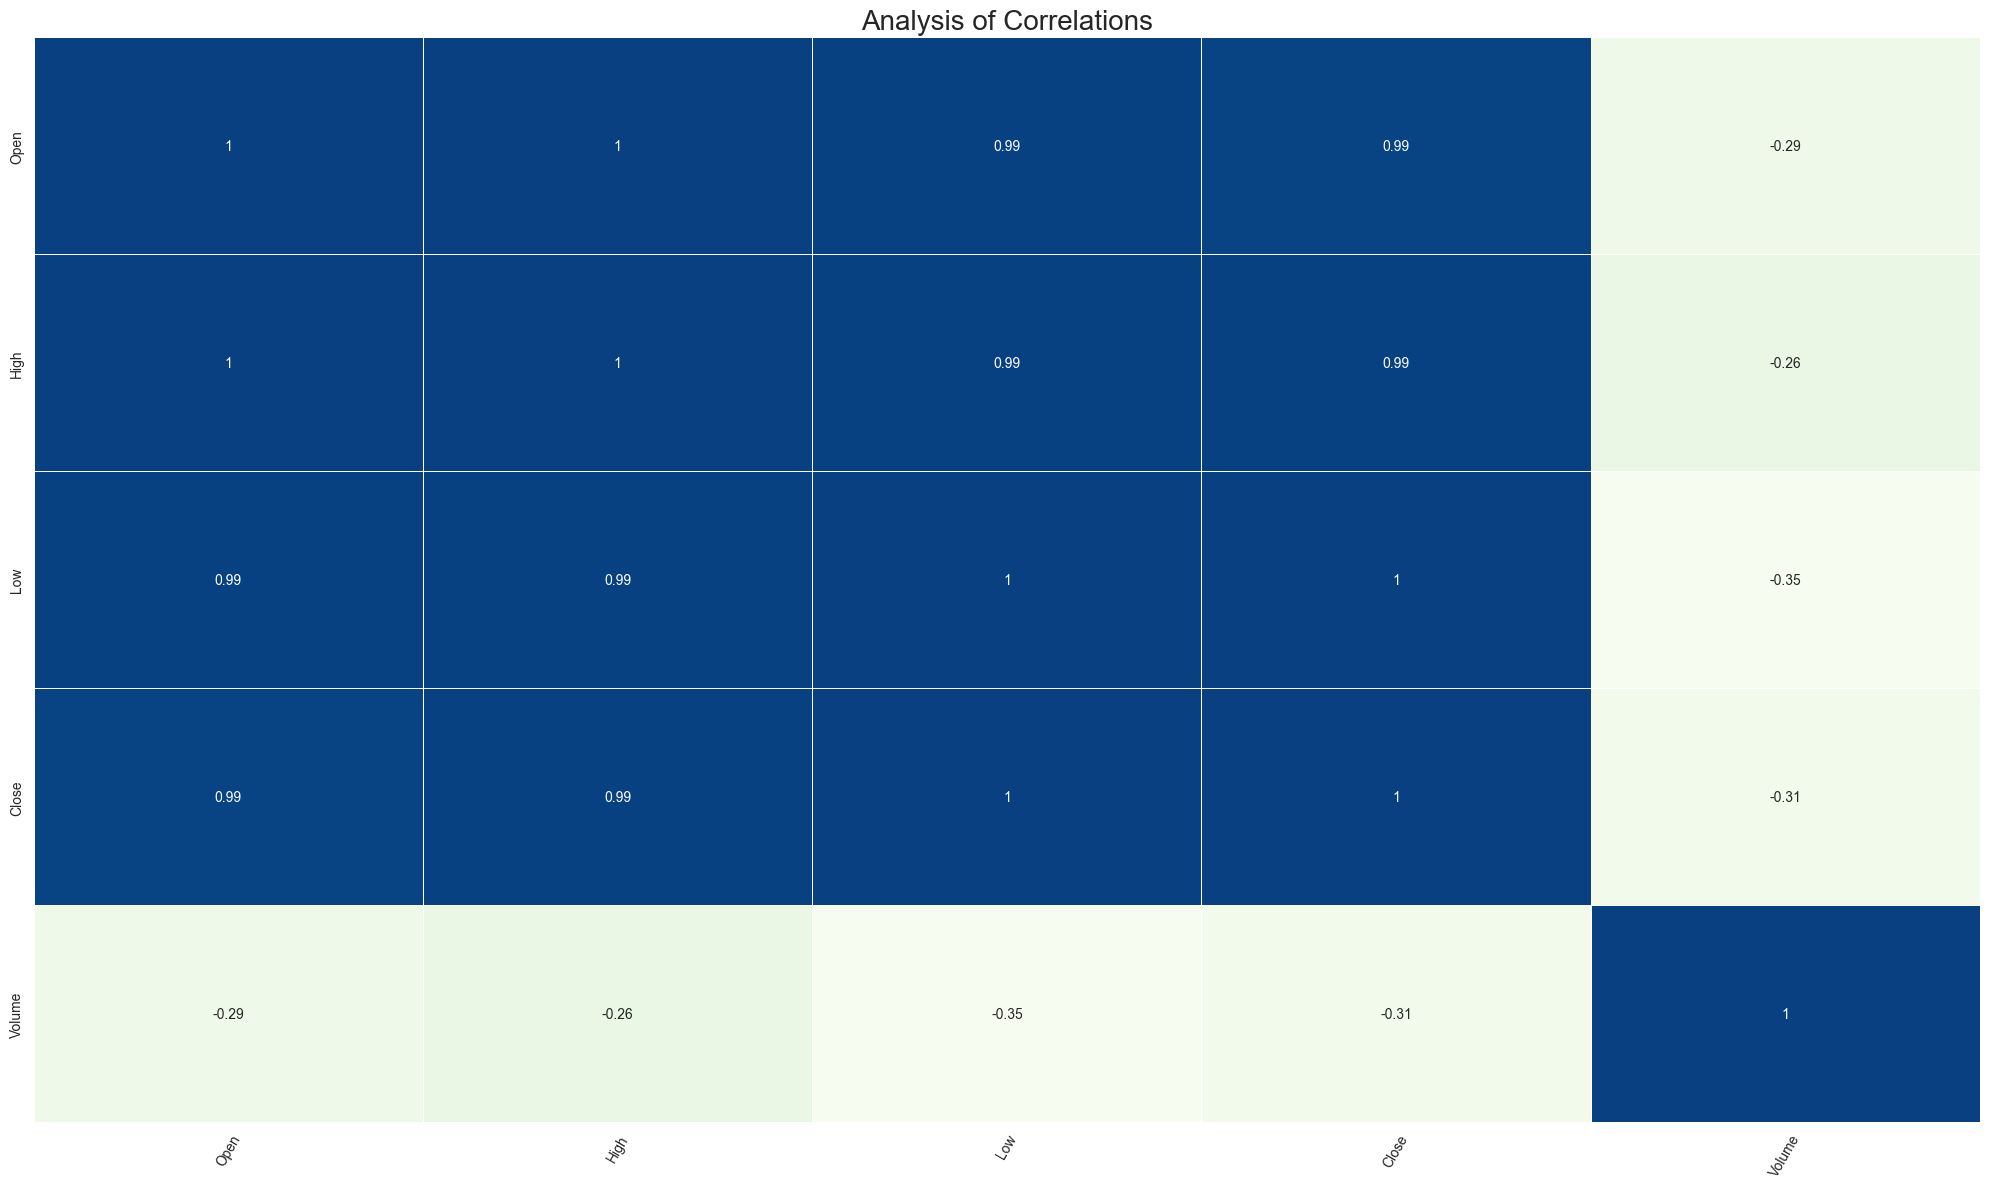

In [96]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(numeric_only=True), cmap="GnBu", annot=True, linewidths=.6 , cbar = False)
plt.xticks(rotation=60, size=10)
plt.yticks(size=10)
plt.title('Analysis of Correlations', size=20)
plt.tight_layout()
plt.show()

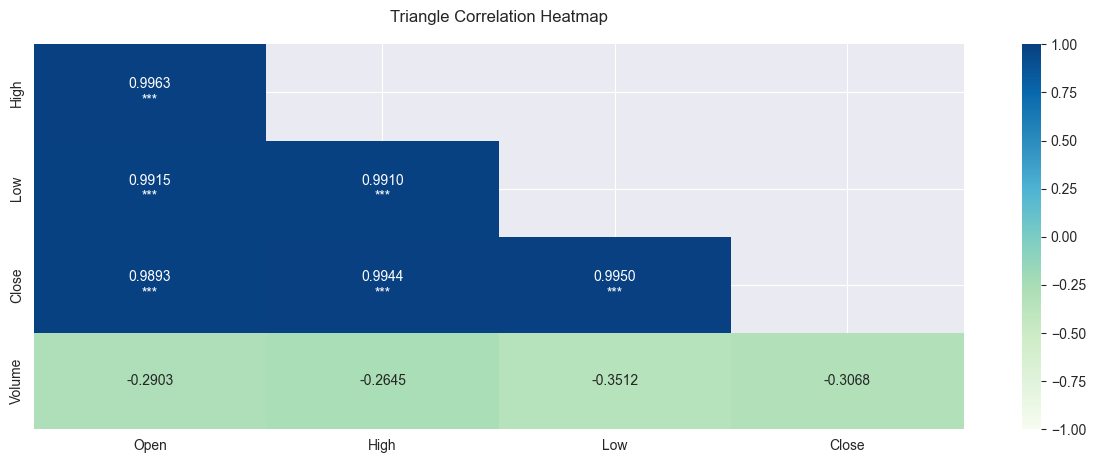

In [97]:
corr = df.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr) < cut_off
corr = corr[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n*')
          + ('' if abs(val) < extreme_2 else '*')
          + ('' if abs(val) < extreme_3 else '*')
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='GnBu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 12}, pad=16)
plt.show()

<h2>Further analysis confirms strong correlation between prices. However the correlation between them and volume remains weak. It also further confirms multimodal distribution.<h2>

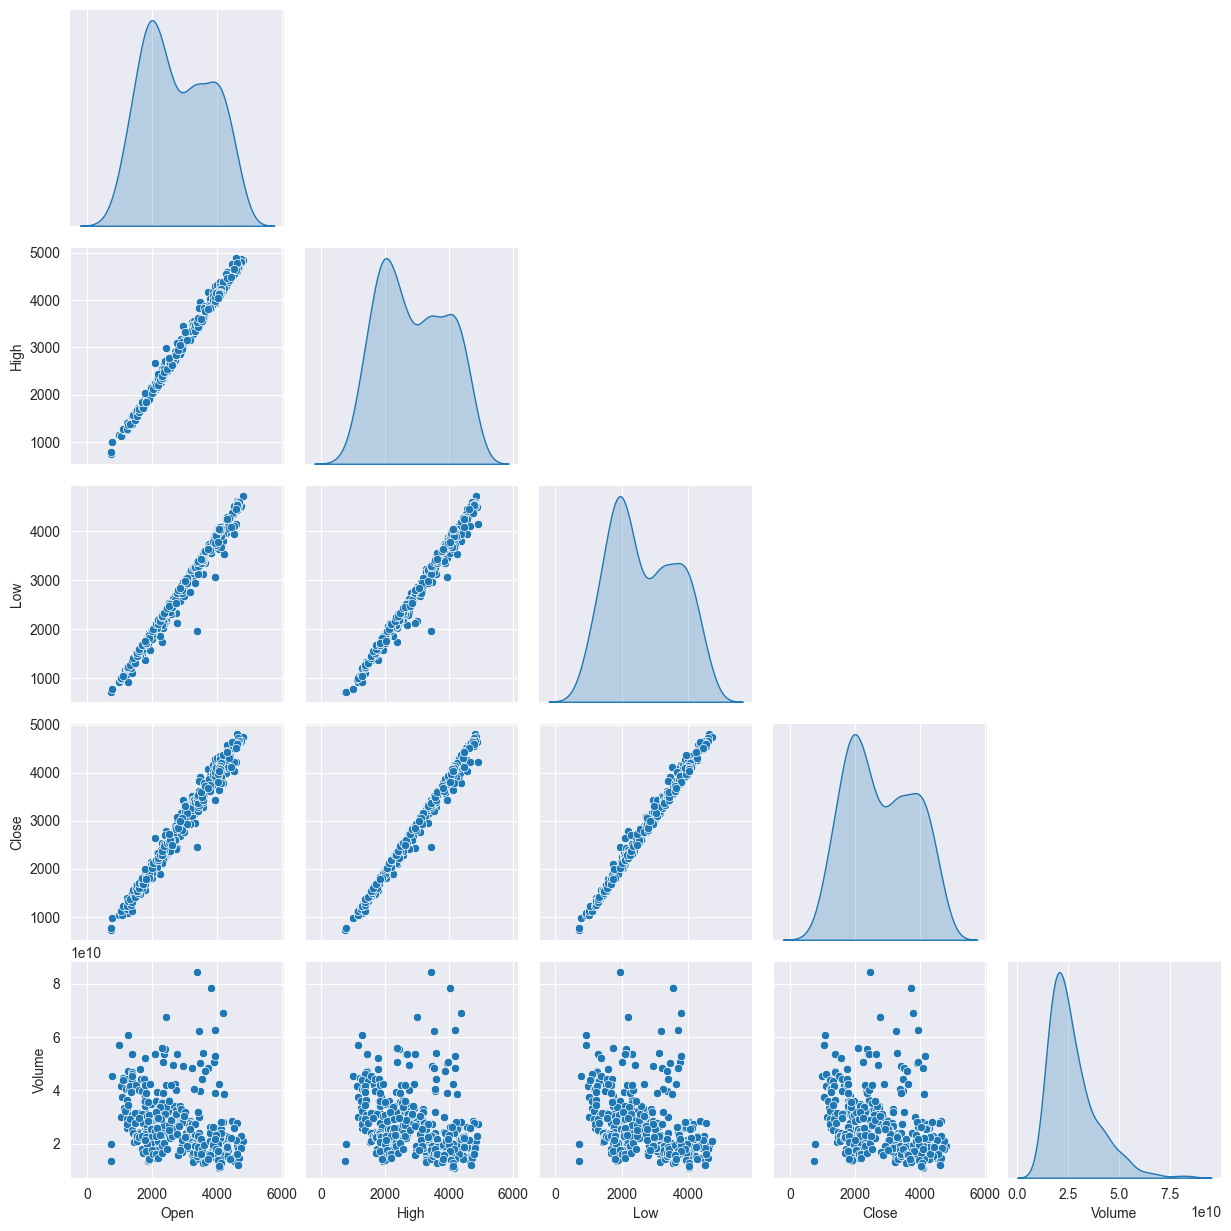

In [98]:
custom_palette = sns.color_palette(['#2a9d8f', '#f4a261'])
sns.pairplot(data=df, diag_kind='kde', palette=custom_palette,corner=True)
plt.gcf().set_facecolor('#ffffff')
plt.show()

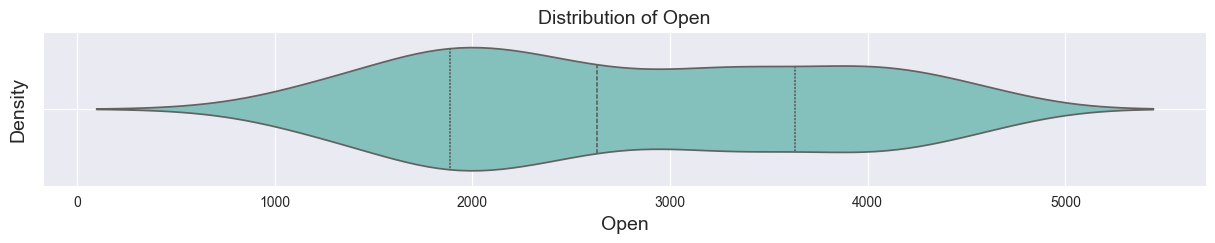

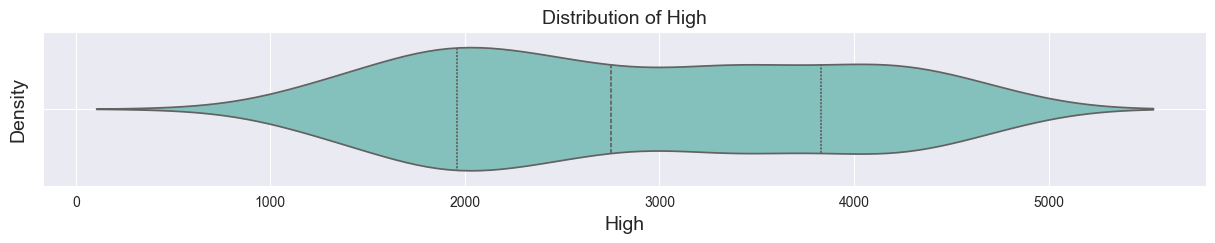

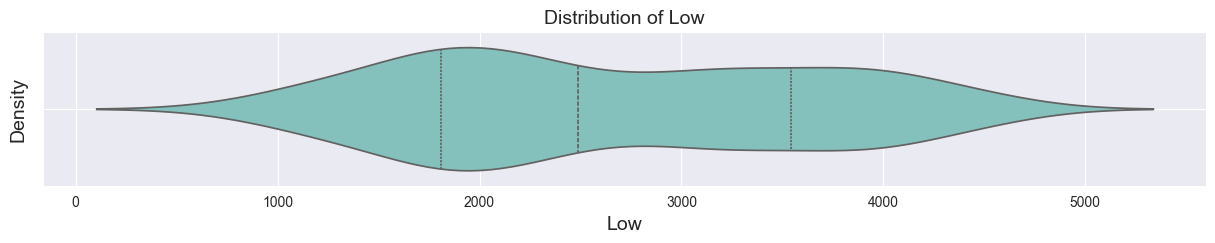

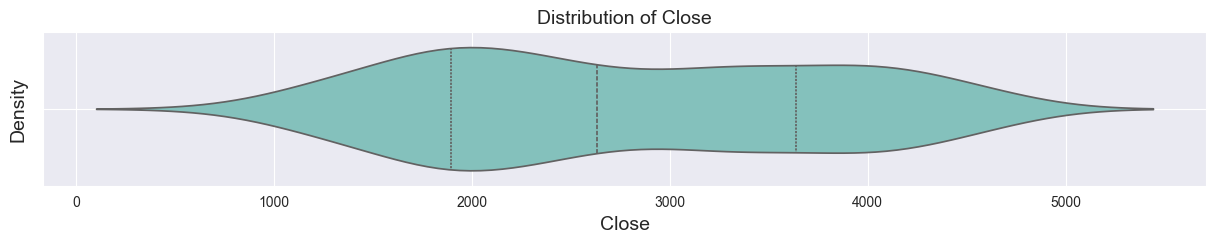

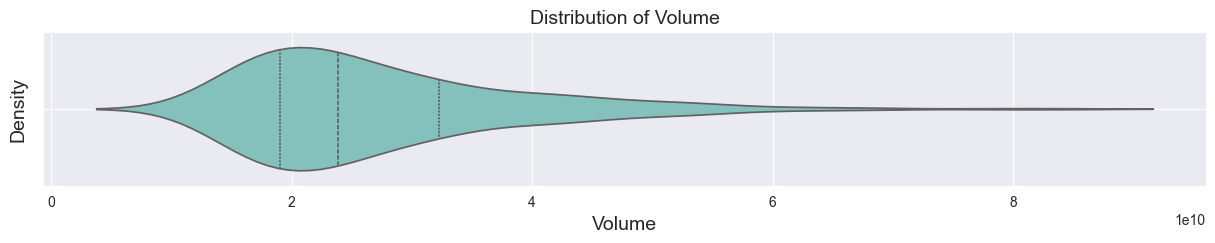

In [99]:
palette = "GnBu"
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.violinplot(x=df[column], palette=palette, inner="quartile")  
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True)
    plt.show()

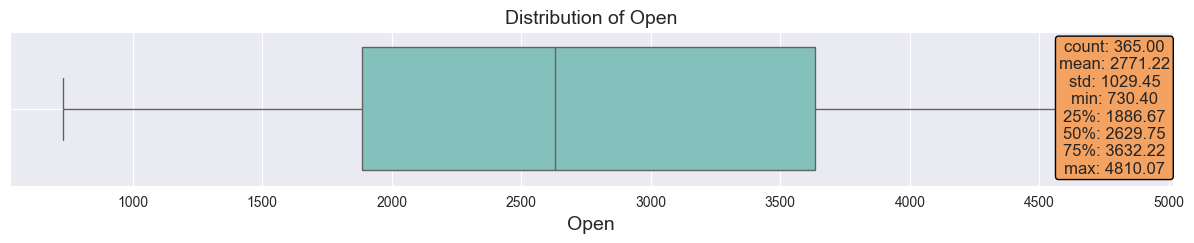

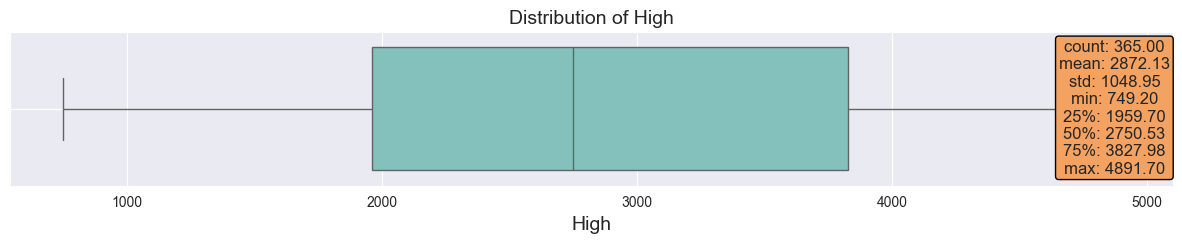

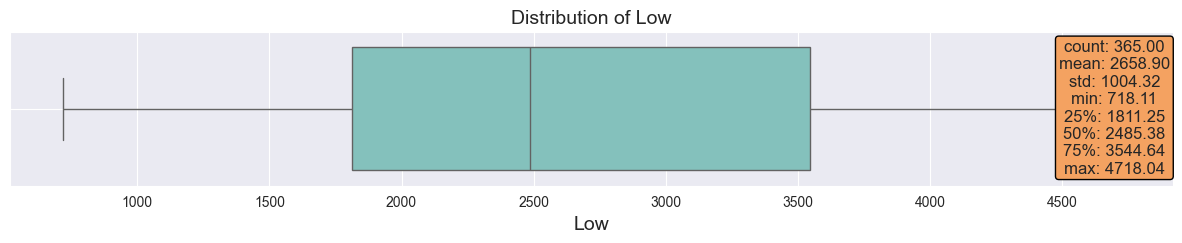

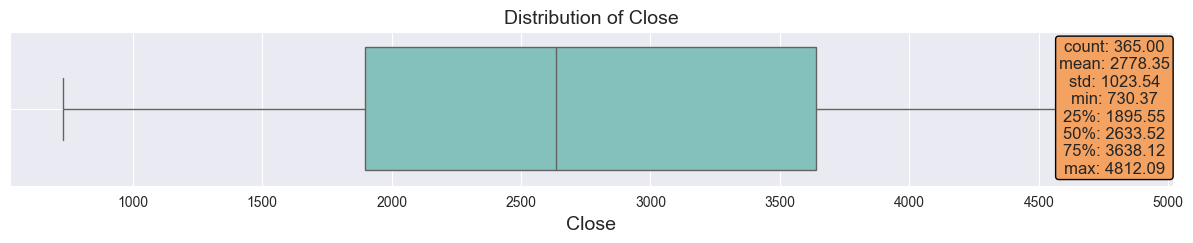

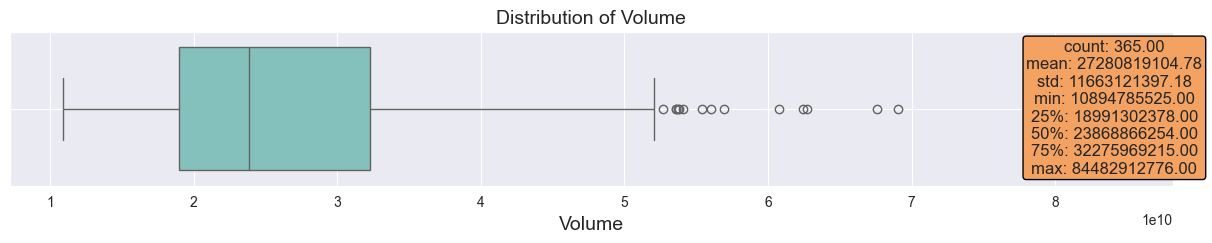

In [100]:
palette = "GnBu" 
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.boxplot(x=df[column], palette=palette)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    stats = df[column].describe()
    stats_text = "\n".join([f"{key}: {value:.2f}" for key, value in stats.items()])
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', 
             horizontalalignment='center', bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='#f4a261'))
    plt.grid(True) 
    plt.show()

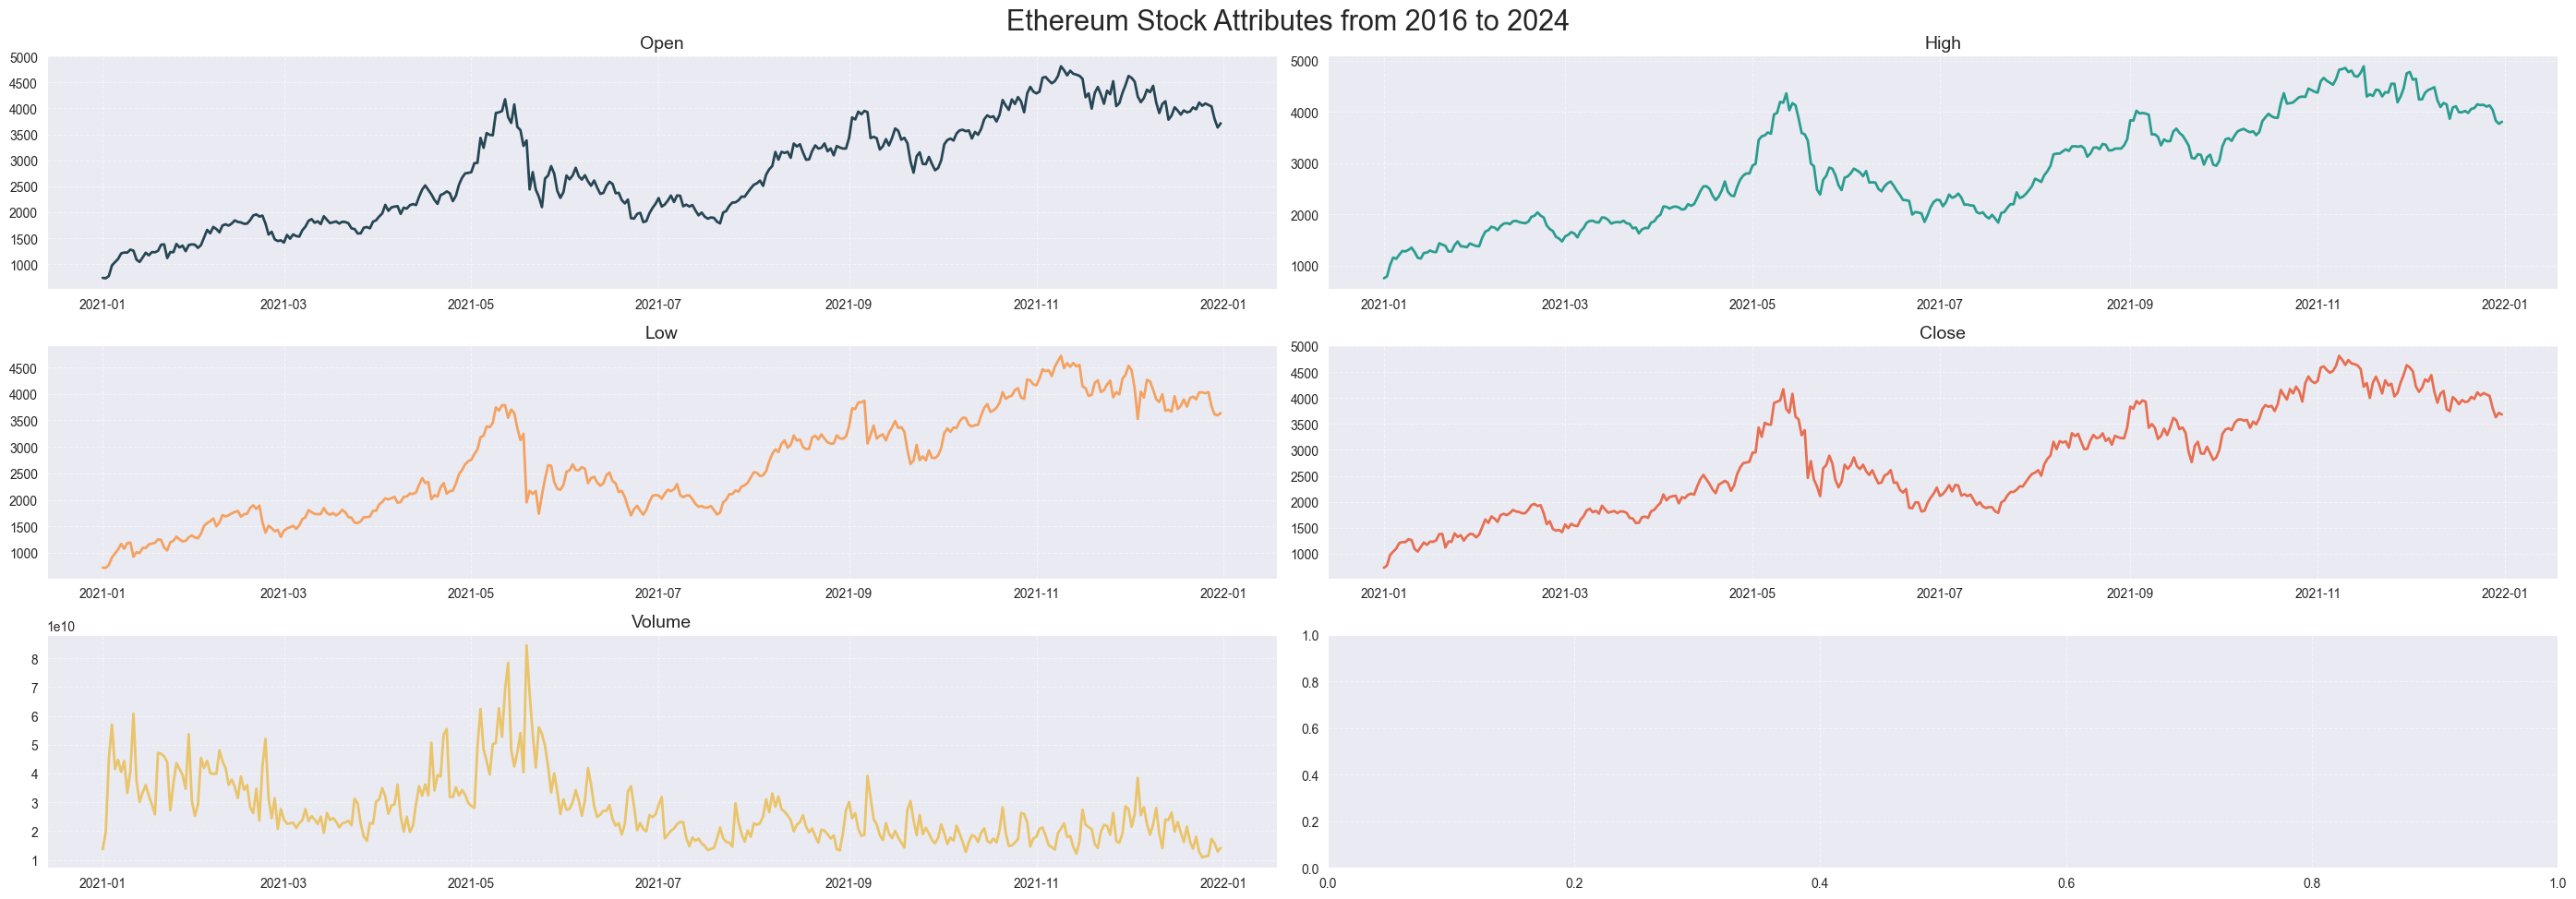

In [101]:
import matplotlib.pyplot as plt
x=df.index
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51','#e9c46a', '#e9d8a6']
plt.figure(figsize=(28, 10))
plt.subplot(3, 2, 1)
plt.plot(x, df['Open'], color=colors[0], linewidth=2)
plt.title('Open', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 2)
plt.plot(x, df['High'], color=colors[1], linewidth=2)
plt.title('High', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 3)
plt.plot(x, df['Low'], color=colors[2], linewidth=2)
plt.title('Low', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 4)
plt.plot(x, df['Close'], color=colors[3], linewidth=2)
plt.title('Close', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 5)
plt.plot(x, df['Volume'], color=colors[4], linewidth=2)
plt.title('Volume', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 6)
plt.grid(True, linestyle='--', alpha=0.5)
plt.suptitle('Ethereum Stock Attributes from 2016 to 2024', fontsize=22, y=0.97)
plt.tight_layout()
plt.show()


In [102]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,1.365200e+10
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,1.974077e+10
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,4.520046e+10
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,5.694599e+10
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,4.153593e+10


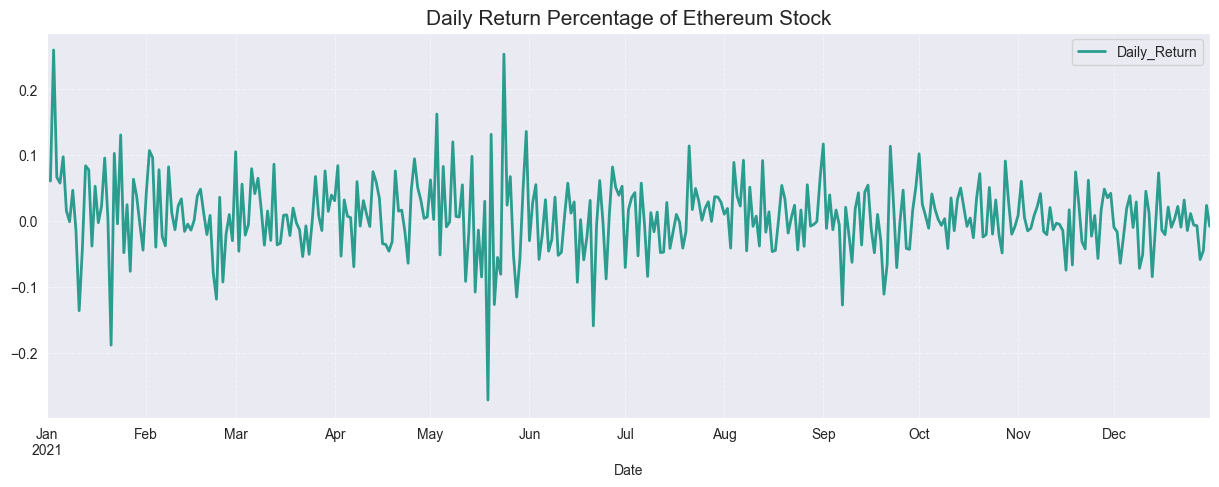

In [103]:
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return'].plot(legend=True, figsize=(15, 5), color='#2a9d8f', linewidth=2)
plt.title('Daily Return Percentage of Ethereum Stock', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<h2>Modeling data</h2>

In [104]:
if os.path.isfile('./paper_data/masked_ticker.csv'):
    df5 = pd.read_csv('./paper_data/masked_ticker.csv')
else:
    tck = yf.Ticker("ETH-USD")
    # defining the start date 
    start_date = "2021-01-01"
    end_date = '2022-01-01'
    # historical data
    df5 = tck.history(start=start_date, end=end_date)
    df5 = df5.drop(['Dividends', 'Stock Splits'], axis=1)

In [105]:
df5.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,13652004358
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,19740771179
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,45200463368
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,56945985763
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,41535932781


In [106]:
if os.path.isfile('../paper_data/masked_ticker.csv'):
    pass
else:
    df5.to_csv('./paper_data/masked_ticker.csv')

In [107]:
df5 = df5.reset_index()

In [108]:
df5['Volume'] = df5['Volume'].astype('float64')

<h2>Using indicators to further analyse the data</h2>

In [109]:
def get_tech_ind(data):
    data['MA5'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA10'] = data.iloc[:,4].rolling(window=10).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bands
    data['8SD'] = data.iloc[:, 4].rolling(8).std()
    data['upper_band'] = data['MA10'] + (data['8SD'] * 2)
    data['lower_band'] = data['MA10'] - (data['8SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    return data

In [110]:
start_date = '2015-01-01'
end_date = '2025-01-01'

mask = (df5['Date'] >= start_date) & (df5['Date'] < end_date)

df5 = df5.loc[mask]

In [111]:
df5.tail(3)

,Date,Open,High,Low,Close,Volume
362,2021-12-29 00:00:00+00:00,3797.436279,3827.981934,3612.795898,3628.531738,1.572256e+10
363,2021-12-30 00:00:00+00:00,3632.219727,3767.559814,3595.204834,3713.852051,1.292538e+10
364,2021-12-31 00:00:00+00:00,3713.430176,3807.288818,3636.869873,3682.632812,1.415729e+10


<h2>Appending the data from sentiment analysis file we export into the other folder.</h2>

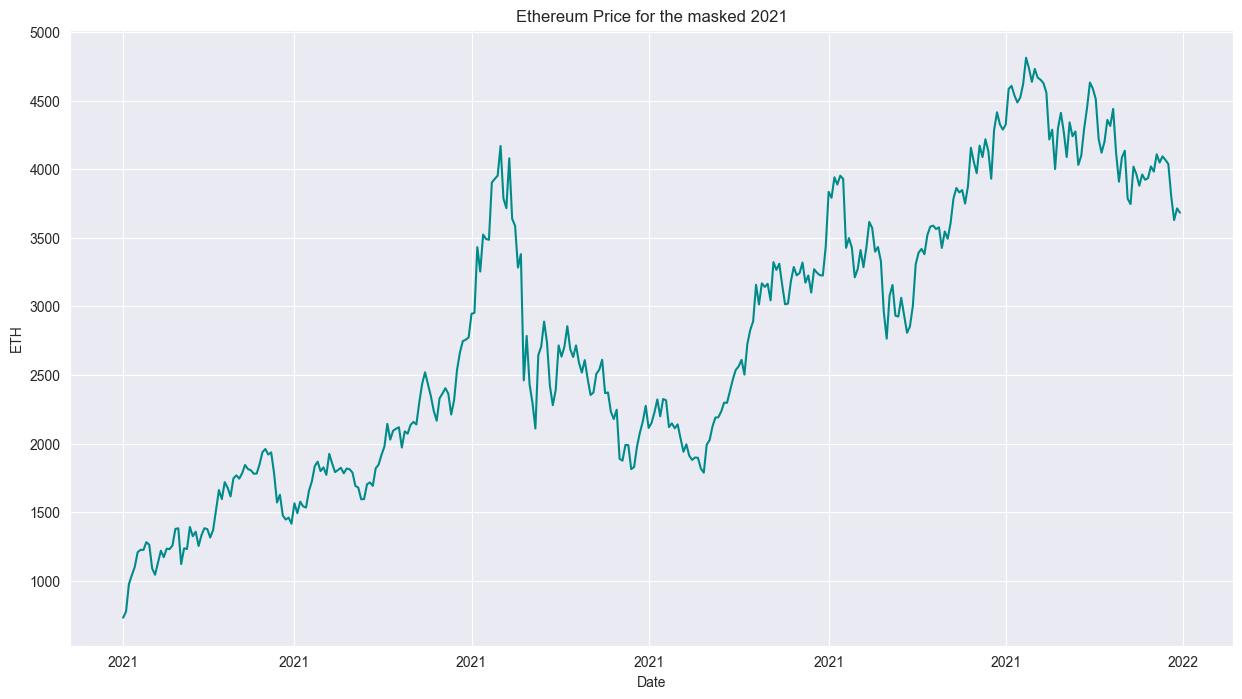

In [112]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df5['Date'], df5['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="ETH", title="Ethereum Price for the masked 2021")

ax.xaxis.set_major_formatter(DateFormatter("%Y"))

plt.show()

In [113]:
tech_df = get_tech_ind(df5)
dataset = tech_df.iloc[10:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-11 00:00:00+00:00,1261.622925,1261.622925,924.922607,1090.145386,6.073363e+10,1198.637556,1118.073859,36.767167,89.245201,1296.564261,939.583456,1147.247263
1,2021-01-12 00:00:00+00:00,1088.526733,1149.240234,1012.764160,1043.434570,3.749460e+10,1190.555908,1144.963818,26.421413,88.539272,1322.042362,967.885275,1078.038671
2,2021-01-13 00:00:00+00:00,1043.740967,1134.338501,994.549072,1130.739380,3.010979e+10,1179.645508,1160.486987,34.872771,85.214707,1330.916402,990.057572,1113.172499
3,2021-01-14 00:00:00+00:00,1130.231201,1244.163086,1093.060791,1218.453003,3.341092e+10,1178.613351,1178.308984,38.569672,85.764193,1349.837370,1006.780598,1183.359516
4,2021-01-15 00:00:00+00:00,1221.877197,1250.505859,1090.721069,1171.834595,3.597204e+10,1171.132987,1185.491833,22.663302,84.168607,1353.829048,1017.154619,1175.676235


In [114]:
df5['Date'] = pd.to_datetime(df5['Date'], utc=True)

<h2>Visualize the indicators</h2>

In [115]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA5'], label='Moving Average (5 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA10'], label='Moving Average (10 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['8SD'], label='Moving Average (8 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['EMA'], label='Exponential Moving Average (8 days)', color='r', linestyle='-.')
    
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

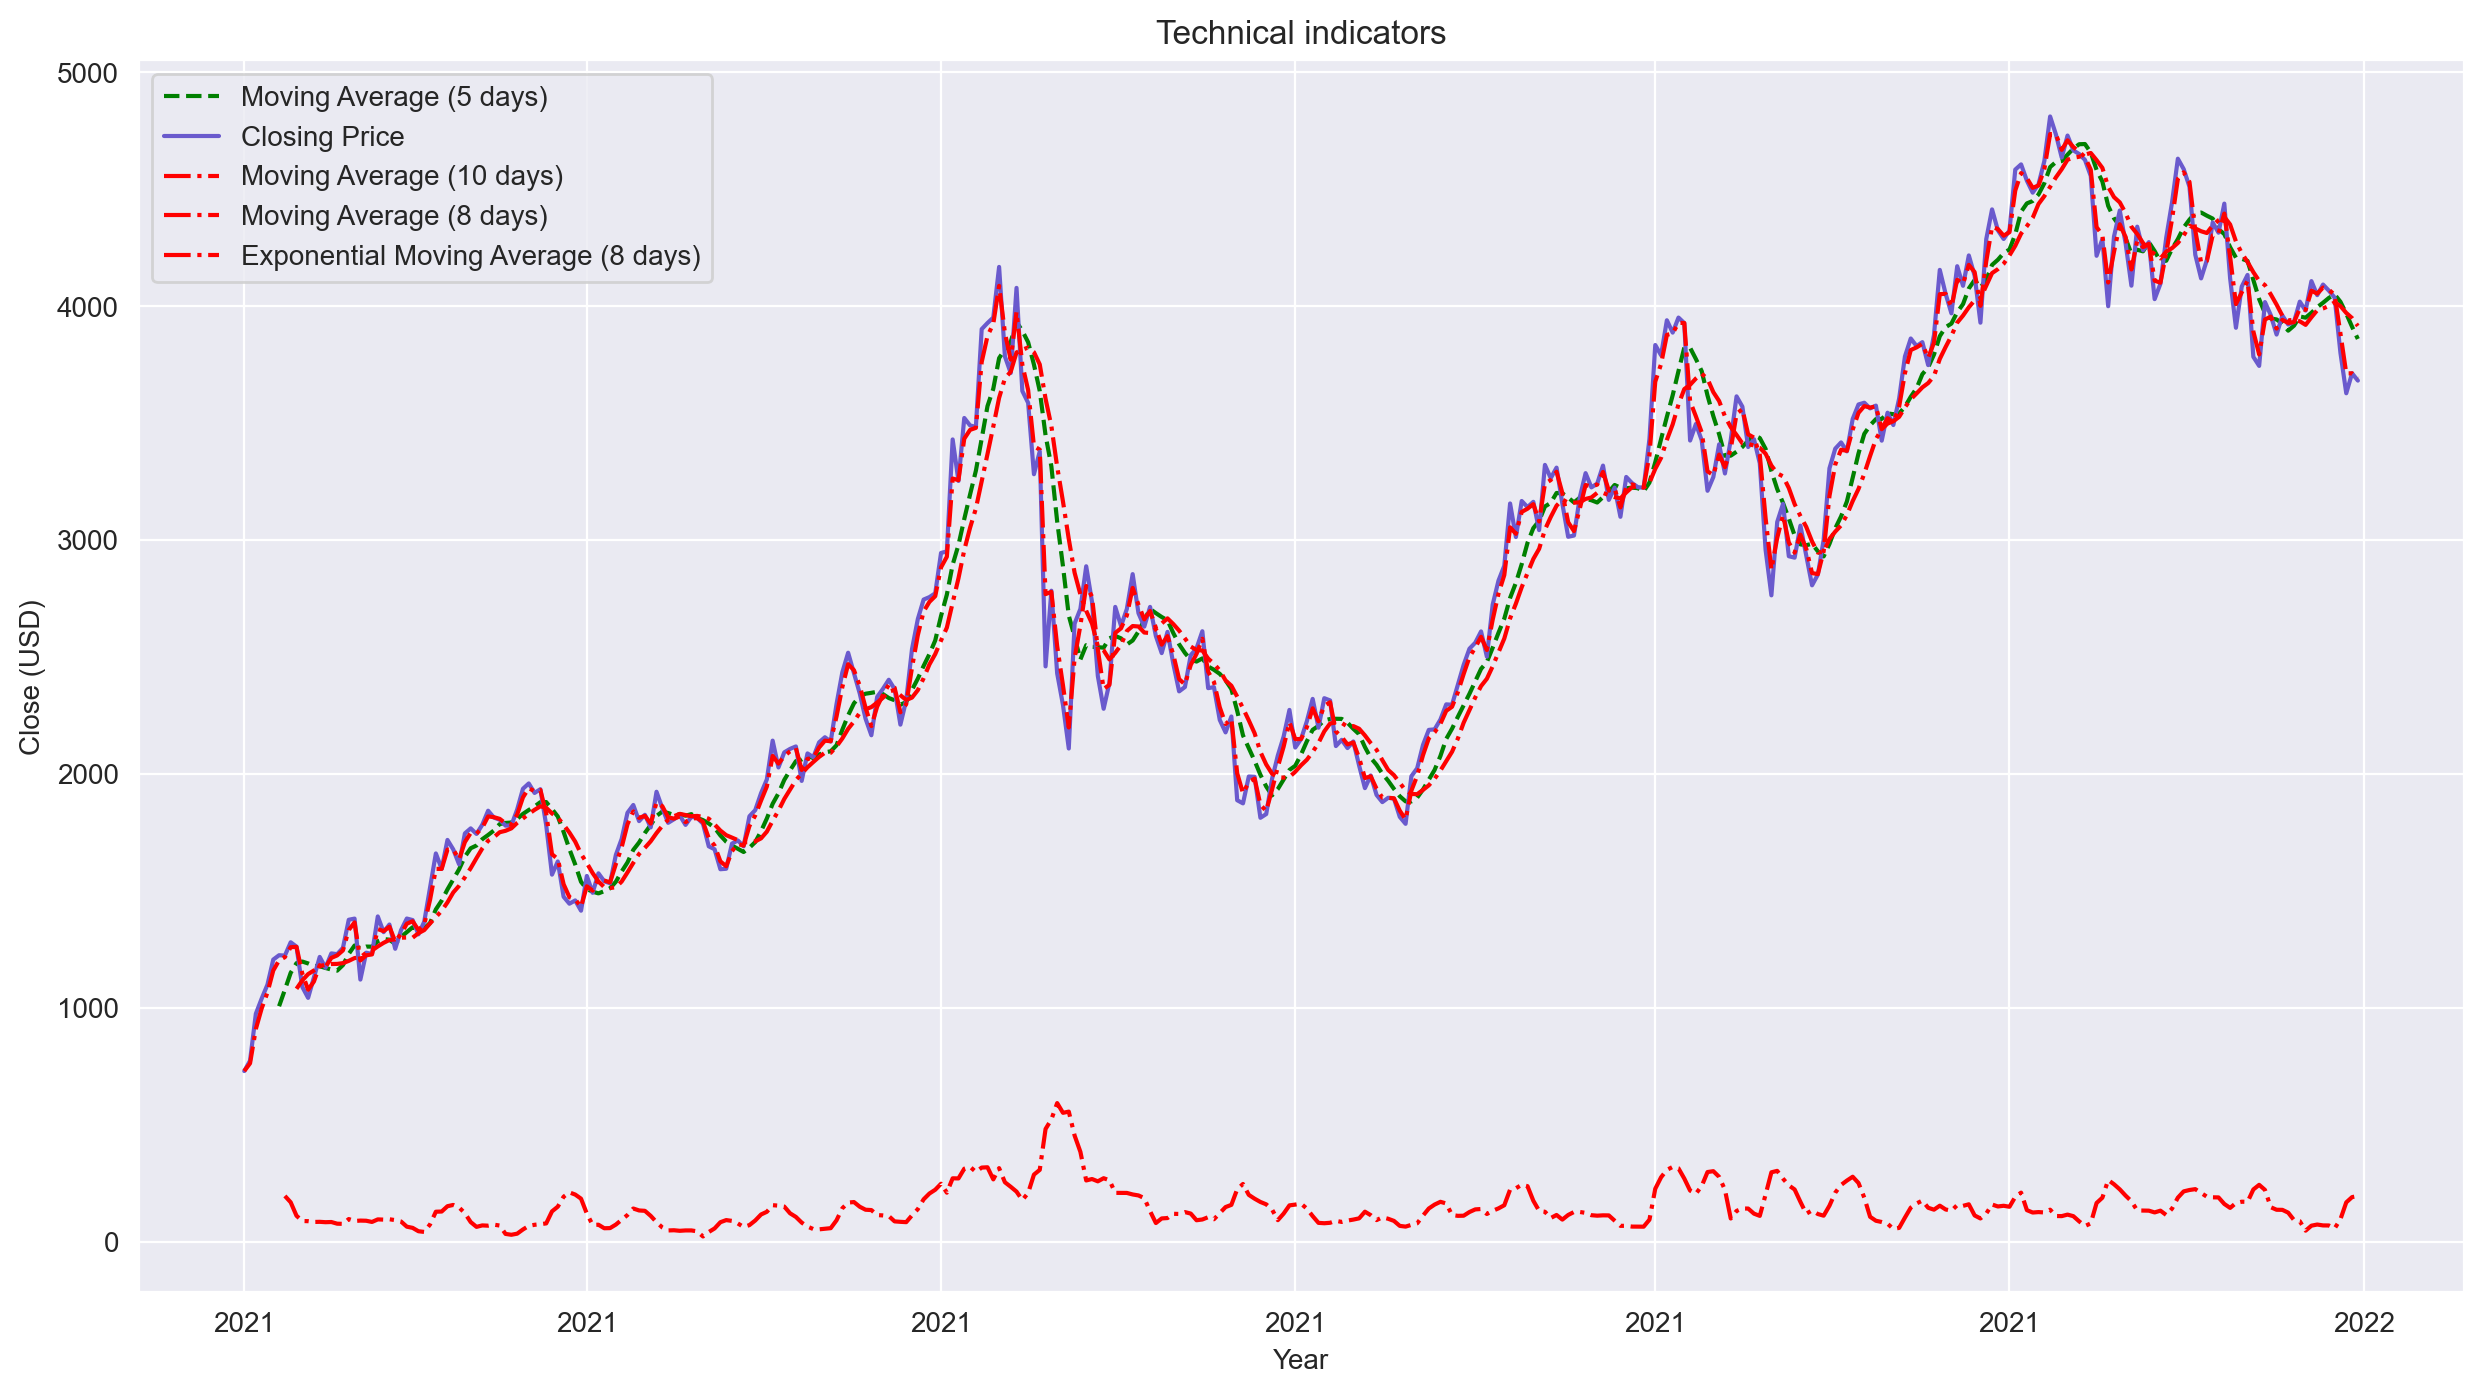

In [116]:
tech_ind(df5)

<h3>5 days and 10 days dataset copy</h3>

In [117]:
dataset_5_days = df5.iloc[6:,:].reset_index(drop=True)
dataset_5_days.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-07 00:00:00+00:00,1208.078369,1282.579590,1167.443115,1225.678101,4.046803e+10,1007.634234,NaN,118.907470,NaN,NaN,NaN,1203.904779
1,2021-01-08 00:00:00+00:00,1225.967896,1273.827515,1076.081543,1224.197144,4.433483e+10,1078.181318,NaN,101.722619,196.472853,NaN,NaN,1217.435084
2,2021-01-09 00:00:00+00:00,1223.740479,1303.871826,1182.270386,1281.077271,3.323311e+10,1150.544503,NaN,93.678942,169.191093,NaN,NaN,1259.865364
3,2021-01-10 00:00:00+00:00,1280.871094,1347.926147,1194.715576,1262.246704,4.061694e+10,1191.507220,1082.096075,73.782225,111.858852,1305.813780,858.378371,1261.452951
4,2021-01-11 00:00:00+00:00,1261.622925,1261.622925,924.922607,1090.145386,6.073363e+10,1198.637556,1118.073859,36.767167,89.245201,1296.564261,939.583456,1147.247263


In [118]:
dataset_10_days = df5.iloc[11:,:].reset_index(drop=True)
dataset_10_days.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-12 00:00:00+00:00,1088.526733,1149.240234,1012.764160,1043.434570,3.749460e+10,1190.555908,1144.963818,26.421413,88.539272,1322.042362,967.885275,1078.038671
1,2021-01-13 00:00:00+00:00,1043.740967,1134.338501,994.549072,1130.739380,3.010979e+10,1179.645508,1160.486987,34.872771,85.214707,1330.916402,990.057572,1113.172499
2,2021-01-14 00:00:00+00:00,1130.231201,1244.163086,1093.060791,1218.453003,3.341092e+10,1178.613351,1178.308984,38.569672,85.764193,1349.837370,1006.780598,1183.359516
3,2021-01-15 00:00:00+00:00,1221.877197,1250.505859,1090.721069,1171.834595,3.597204e+10,1171.132987,1185.491833,22.663302,84.168607,1353.829048,1017.154619,1175.676235
4,2021-01-16 00:00:00+00:00,1171.443115,1290.053589,1157.623779,1233.537598,3.231924e+10,1164.341605,1188.134375,23.505370,84.965703,1358.065782,1018.202968,1214.250478


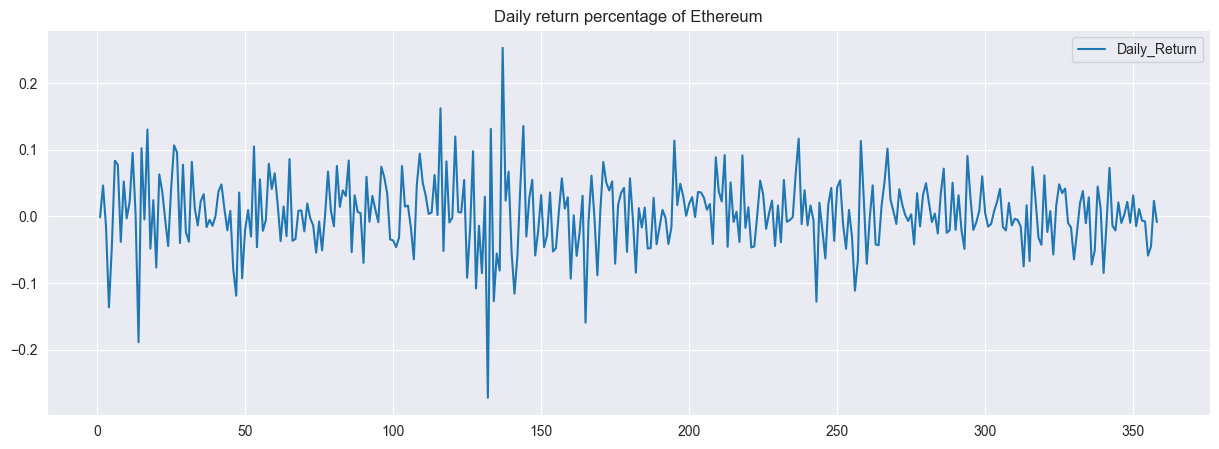

In [119]:
dataset_5_days['Daily_Return'] = dataset_5_days['Close'].pct_change()

# plot the daily return percentage
dataset_5_days.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of Ethereum')
plt.show()

<h2>Final Data Preparation</h2>
<h3>Change values for data training</h3>

(ZACZYNAMY OD TEGO MIEJSCA)

In [120]:
import numpy as np

# jeśli nie ma trade_sign → utwórz
if 'trade_sign' not in dataset_5_days.columns:
    # wariant 1: znak jednodniowej zmiany ceny Close
    ds = dataset_5_days.copy()
    close = ds['Close'].astype(float)
    trade_sign = np.sign(close.diff()).fillna(0.0)  # -1, 0, 1
    ds['trade_sign'] = trade_sign
    dataset_5_days = ds.dropna().copy()

print(dataset_5_days.columns.tolist())

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'MACD', '8SD', 'upper_band', 'lower_band', 'EMA', 'Daily_Return', 'trade_sign']


In [121]:
dataset_5_days_trade_sign = dataset_5_days[['Open', 'Close', 'High', 'Low', 'trade_sign']]

In [122]:
dataset_5_days_trade_sign.head()

,Open,Close,High,Low,trade_sign
3,1280.871094,1262.246704,1347.926147,1194.715576,-1.0
4,1261.622925,1090.145386,1261.622925,924.922607,-1.0
5,1088.526733,1043.434570,1149.240234,1012.764160,-1.0
6,1043.740967,1130.739380,1134.338501,994.549072,1.0
7,1130.231201,1218.453003,1244.163086,1093.060791,1.0


In [123]:
# normalize 5 days data
scaler = MinMaxScaler(feature_range=(-1,1)).fit(dataset_5_days_trade_sign)

data_5_days_trade_sign = scaler.transform(dataset_5_days_trade_sign)
print(data_5_days_trade_sign)

[[-0.87407895 -0.8838778  -0.88630991 -0.85774601 -1.        ]
 [-0.88430013 -0.97521087 -0.93224806 -1.         -1.        ]
 [-0.97621782 -1.         -0.99206799 -0.9536837  -1.        ]
 ...
 [ 0.46226968  0.37189456  0.43379344  0.41723742 -1.        ]
 [ 0.37453624  0.41717351  0.40163149  0.40796216  1.        ]
 [ 0.41766068  0.40060566  0.42277875  0.42993093 -1.        ]]


<h2>5 day long sequences</h2>

In [124]:
seq_len_5_days=6
sequences_5_days_trade_sign=[]
for index in range(len(data_5_days_trade_sign) - seq_len_5_days + 1): 
    sequences_5_days_trade_sign.append(data_5_days_trade_sign[index: index + seq_len_5_days])
sequences_5_days_trade_sign = np.array(sequences_5_days_trade_sign)

sequences_5_days_trade_sign

array([[[-0.87407895, -0.8838778 , -0.88630991, -0.85774601,
         -1.        ],
        [-0.88430013, -0.97521087, -0.93224806, -1.        ,
         -1.        ],
        [-0.97621782, -1.        , -0.99206799, -0.9536837 ,
         -1.        ],
        [-1.        , -0.95366789, -1.        , -0.96328799,
          1.        ],
        [-0.95407188, -0.90711884, -0.94154172, -0.91134563,
          1.        ],
        [-0.90540594, -0.93185893, -0.93816554, -0.91257929,
         -1.        ]],

       [[-0.88430013, -0.97521087, -0.93224806, -1.        ,
         -1.        ],
        [-0.97621782, -1.        , -0.99206799, -0.9536837 ,
         -1.        ],
        [-1.        , -0.95366789, -1.        , -0.96328799,
          1.        ],
        [-0.95407188, -0.90711884, -0.94154172, -0.91134563,
          1.        ],
        [-0.90540594, -0.93185893, -0.93816554, -0.91257929,
         -1.        ],
        [-0.93218749, -0.89911354, -0.91711476, -0.87730344,
          1. 

In [125]:
valid_set_size_percentage_trade_sign = 10 
test_set_size_percentage_trade_sign = 10 

valid_set_size_trade_sign = int(np.round(valid_set_size_percentage_trade_sign/100*sequences_5_days_trade_sign.shape[0]))  
test_set_size_trade_sign  = int(np.round(test_set_size_percentage_trade_sign/100*sequences_5_days_trade_sign.shape[0]))
train_set_size_trade_sign = sequences_5_days_trade_sign.shape[0] - (valid_set_size_trade_sign + test_set_size_trade_sign)

x_train_5_days_trade_sign = sequences_5_days_trade_sign[:train_set_size_trade_sign,:-1,:]
y_train_5_days_trade_sign = sequences_5_days_trade_sign[:train_set_size_trade_sign,-1,:]
    
x_valid_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign:train_set_size_trade_sign+valid_set_size_trade_sign,:-1,:]
y_valid_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign:train_set_size_trade_sign+valid_set_size_trade_sign,-1,:]
    
x_test_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign+valid_set_size_trade_sign:,:-1,:]
y_test_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign+valid_set_size_trade_sign:,-1,:]

<h2>Building Neural Network and its components with Torch<h2>

In [126]:
from torch.utils.data import Dataset, DataLoader
import torch

class SequenceDataset(Dataset):
    """
    Gwarantuje spójne kształty:
      x: (N, T-1, F)
      y: (N, F)
    """
    def __init__(self, x_np, y_np):
        x = torch.as_tensor(x_np, dtype=torch.float32)
        y = torch.as_tensor(y_np, dtype=torch.float32)

        # Jeśli ktoś przez pomyłkę poda (N,1,F) albo (N,T,F) -> weź ostatni krok
        if y.ndim == 3:
            y = y[:, -1, :]

        assert x.ndim == 3, f"Expected x.ndim==3, got {x.ndim}"
        assert y.ndim == 2, f"Expected y.ndim==2, got {y.ndim}"
        assert x.shape[0] == y.shape[0], "x and y must have same N"
        assert x.shape[2] == y.shape[1], "feature dim must match (F)"

        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def make_loaders(
    x_train, y_train,
    x_valid, y_valid,
    x_test,  y_test,
    batch_size: int = 32,
    shuffle_train: bool = True,
    num_workers: int = 0,
    pin_memory: bool = False,
):
    train_ds = SequenceDataset(x_train, y_train)
    valid_ds = SequenceDataset(x_valid, y_valid)
    test_ds  = SequenceDataset(x_test,  y_test)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_train,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    return train_dl, valid_dl, test_dl


# --- zbuduj dataloadery z już przygotowanych tablic ---
train_dataloader_5_days_trade_sign, \
valid_dataloader_5_days_trade_sign, \
test_dataloader_5_days_trade_sign = make_loaders(
    x_train_5_days_trade_sign, y_train_5_days_trade_sign,
    x_valid_5_days_trade_sign, y_valid_5_days_trade_sign,
    x_test_5_days_trade_sign,  y_test_5_days_trade_sign,
    batch_size=32, shuffle_train=True, num_workers=0, pin_memory=False
)

# Kontrola kształtów
xb, yb = next(iter(train_dataloader_5_days_trade_sign))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))  # (B, T-1, F), (B, F)


Batch shapes: (32, 5, 5) (32, 5)


In [127]:
import torch.nn.functional as F  # opcjonalnie
from torch import nn

class NeuralNetwork(nn.Module):
    """
    Wejście:  x -> (B, T, F)
    Wyjście:  y -> (B, F)   (predykcja ostatniego kroku)
    """
    def __init__(self, num_feature: int, hidden_size: int = 64, num_layers: int = 1, dropout: float = 0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_feature,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, num_feature)

    def forward(self, x):
        # x: (B, T, F)
        output, (hidden, cell) = self.lstm(x)
        last_hidden = hidden[-1]         # (B, hidden_size)
        out = self.head(last_hidden)     # (B, F)
        return out


In [128]:
model = NeuralNetwork(5)

In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [130]:
from torchinfo import summary
summary(model, input_size=(32, 5, 5))  # (batch, seq_len, features)

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [32, 5]                   --
├─LSTM: 1-1                              [32, 5, 64]               18,176
├─Linear: 1-2                            [32, 5]                   325
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.07
Estimated Total Size (MB): 0.16

In [131]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse = nn.MSELoss()

In [132]:
def train(dataloader, device="cpu"):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(x)           # (B, F)
        loss = mse(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    return running_loss / max(n_batches, 1)


In [133]:
def evaluate(dataloader, device="cpu"):
    model.eval()
    running_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)        # (B, F)
            loss = mse(pred, y)
            running_loss += loss.item()
            n_batches += 1

    return running_loss / max(n_batches, 1)


<h2>Training and Validation comparison plot function</h2>

In [134]:
def plot_loss(train_losses, valid_losses):
    plt.plot(train_losses, color='black', label='test loss')
    plt.plot(valid_losses, color='blue', label='validation loss')

    plt.title('Loss function comparison')
    plt.xlabel('time')
    plt.ylabel('loss values')
    plt.legend(loc='best')
    plt.show()

<h2>Network training loop</h2>

<h3>This code chunk contains code for best fit model</h3>

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

n_epochs = 1300
patience = 50
best_valid_loss = float('inf')
epochs_no_improve = 0

train_losses = []
valid_losses = []

for epoch_instance in range(1, n_epochs + 1):
    train_loss = train(train_dataloader_5_days_trade_sign, device=device)
    valid_loss = evaluate(valid_dataloader_5_days_trade_sign, device=device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    improved = valid_loss < best_valid_loss - 1e-8
    if improved:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'saved_weights.pt')  # zapisuj state_dict
    else:
        epochs_no_improve += 1

    if epoch_instance % 10 == 0 or improved:
        print(f"Epoch {epoch_instance:4d} | Train: {train_loss:.6f} | Val: {valid_loss:.6f}")

    if epochs_no_improve >= patience:
        print(f"Early stop (patience={patience}) @ epoch {epoch_instance}")
        break


Epoch    1 | Train: 0.358174 | Val: 0.641291
Epoch    2 | Train: 0.306957 | Val: 0.601422
Epoch    3 | Train: 0.254542 | Val: 0.515237
Epoch    4 | Train: 0.231425 | Val: 0.412393
Epoch    5 | Train: 0.215371 | Val: 0.330855
Epoch    6 | Train: 0.206156 | Val: 0.267074
Epoch    7 | Train: 0.203865 | Val: 0.234465
Epoch    8 | Train: 0.203538 | Val: 0.226905
Epoch   10 | Train: 0.201953 | Val: 0.222850
Epoch   11 | Train: 0.201603 | Val: 0.215440
Epoch   12 | Train: 0.201521 | Val: 0.210062
Epoch   13 | Train: 0.200544 | Val: 0.207339
Epoch   14 | Train: 0.200952 | Val: 0.205430
Epoch   15 | Train: 0.199976 | Val: 0.204166
Epoch   16 | Train: 0.200076 | Val: 0.202973
Epoch   17 | Train: 0.199756 | Val: 0.200459
Epoch   19 | Train: 0.198932 | Val: 0.196445
Epoch   20 | Train: 0.198810 | Val: 0.195575
Epoch   22 | Train: 0.198303 | Val: 0.193900
Epoch   23 | Train: 0.198482 | Val: 0.192530
Epoch   24 | Train: 0.197606 | Val: 0.191595
Epoch   25 | Train: 0.198721 | Val: 0.190046
Epoch   26

<h2> Visualization of results</h2>

In [136]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

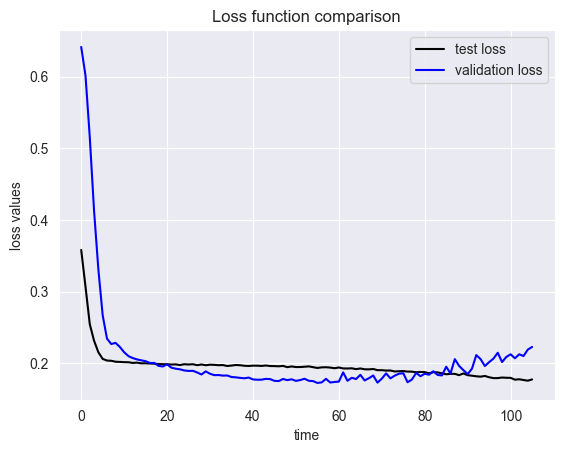

In [137]:
plot_loss(train_losses=train_losses, valid_losses=valid_losses)

<h2>Loading saved weights data and conducting Predictions</h2>
<h3>Continued part after skipping the hyperparameter tuning</h3>

In [138]:
# Ładujemy model i przełączamy w eval — UWAGA: ładujemy state_dict, a nie pełny obiekt!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_test = NeuralNetwork(5).to(device)
state = torch.load('saved_weights.pt', map_location=device)
model_test.load_state_dict(state)
model_test.eval()

@torch.no_grad()
def predict_full(model, loader, device="cpu"):
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pb = model(xb)           # (B, F)
        ys.append(yb.cpu())
        ps.append(pb.cpu())
    y = torch.cat(ys, dim=0).numpy()    # (N_test, F)
    p = torch.cat(ps, dim=0).numpy()    # (N_test, F)
    return y, p

y_test_np, y_pred_np = predict_full(model_test, test_dataloader_5_days_trade_sign, device=device)
print("Prediction shapes:", y_test_np.shape, y_pred_np.shape)


Prediction shapes: (35, 5) (35, 5)


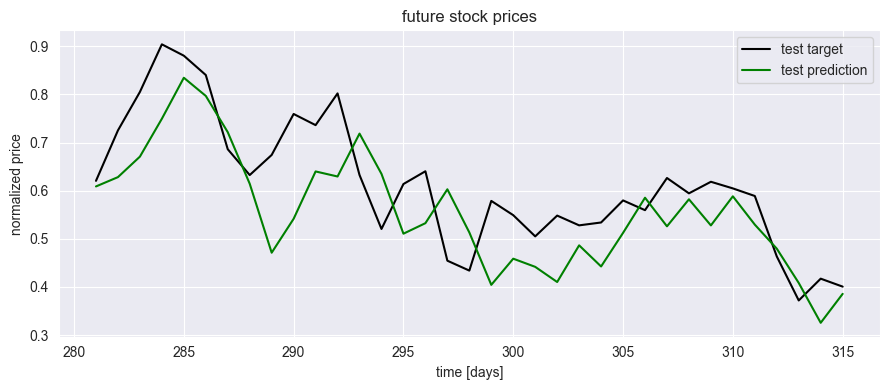

MAE  (Close): 0.08574316650629044
MAPE (Close): 0.14034639298915863


In [139]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# Rysujemy np. 'Close' = idx=1 (Open=0, Close=1, High=2, Low=3, trade_sign=4)
idx = 1
n_train = len(y_train_5_days_trade_sign)
x_axis = np.arange(n_train, n_train + y_test_np.shape[0])

plt.figure(figsize=(9,4))
plt.plot(x_axis, y_test_np[:, idx],  color='black', label='test target')
plt.plot(x_axis, y_pred_np[:, idx],  color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("MAE  (Close):", mean_absolute_error(y_test_np[:, idx], y_pred_np[:, idx]))
print("MAPE (Close):", mean_absolute_percentage_error(y_test_np[:, idx], y_pred_np[:, idx]))


## New after Jarek sugestions

In [140]:
# === KONFIG ===
HORIZONS = [1, 3, 5, 10]     # w krokach (dni / interwały jak w Twoich danych)
INPUT_LEN = 32               # długość okna wejściowego (możesz zwiększyć)
TEST_SIZE = 0.15
VALID_SIZE = 0.15
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 500
PATIENCE = 40
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MH_FEATURES = ['Open', 'Close', 'High', 'Low', 'trade_sign']

# Seed dla powtarzalności
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [141]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Bierzemy dane z istniejącej ramki; jeśli nie masz 'dataset_5_days', użyj tej, którą masz po "New".
if 'dataset_5_days' in globals():
    df_src = dataset_5_days.copy()
else:
    # Jeśli w notatniku masz inną ramkę z tymi samymi kolumnami, podmień tutaj:
    df_src = dataset_5_days_trade_sign.copy()

# Upewnij się, że kolumny są
missing = [c for c in MH_FEATURES if c not in df_src.columns]
if missing:
    raise ValueError(f"Brakuje kolumn w danych: {missing}. Podmień MH_FEATURES lub źródło danych.")

# Skalowanie na osobnym skalerze, żeby nie popsuć wcześniejszych rzeczy
scaler_mh = MinMaxScaler(feature_range=(-1, 1))
X_full_np = scaler_mh.fit_transform(df_src[MH_FEATURES].values)   # shape: (N_all, F)

def build_multi_horizon_sequences(x_full, input_len, horizons):
    """
    Zwraca:
      X: (N, input_len, F)
      Y: (N, H, F)  — gdzie H = len(horizons)
    """
    F = x_full.shape[1]
    H = len(horizons)
    max_h = max(horizons)
    seqs_X, seqs_Y = [], []

    for t in range(input_len, len(x_full) - max_h):
        x_win = x_full[t - input_len:t]                       # (input_len, F)
        y_targets = []
        for h in horizons:
            y_targets.append(x_full[t + h, :])               # (F,)
        y_targets = np.stack(y_targets, axis=0)               # (H, F)
        seqs_X.append(x_win)
        seqs_Y.append(y_targets)

    X = np.stack(seqs_X, axis=0)   # (N, input_len, F)
    Y = np.stack(seqs_Y, axis=0)   # (N, H, F)
    return X, Y

X_mh, Y_mh = build_multi_horizon_sequences(X_full_np, INPUT_LEN, HORIZONS)

N = X_mh.shape[0]
n_test  = int(round(N * TEST_SIZE))
n_valid = int(round(N * VALID_SIZE))
n_train = N - n_test - n_valid
assert n_train > 0 and n_valid > 0 and n_test > 0, "Za mało danych na taki podział."

X_train_mh = X_mh[:n_train]
Y_train_mh = Y_mh[:n_train]
X_valid_mh = X_mh[n_train:n_train+n_valid]
Y_valid_mh = Y_mh[n_train:n_train+n_valid]
X_test_mh  = X_mh[n_train+n_valid:]
Y_test_mh  = Y_mh[n_train+n_valid:]

X_train_mh.shape, Y_train_mh.shape


((220, 32, 5), (220, 4, 5))

[HCR] ep=   1  trainNLL=11.356126  valNLL=2.684380  reg=0.000006
[HCR] ep=  25  trainNLL=1.252150  valNLL=3.085109  reg=0.000012
[HCR] ep=  50  trainNLL=1.250073  valNLL=3.079739  reg=0.000012
[HCR] ep=  75  trainNLL=1.230562  valNLL=3.047578  reg=0.000011
[HCR] ep= 100  trainNLL=1.196308  valNLL=2.991111  reg=0.000009
[HCR] ep= 125  trainNLL=1.121215  valNLL=2.864702  reg=0.000007
[HCR] ep= 150  trainNLL=1.251425  valNLL=3.108172  reg=0.000012
[HCR] ep= 175  trainNLL=1.355927  valNLL=3.251747  reg=0.000032
[HCR] ep= 200  trainNLL=1.358334  valNLL=3.254672  reg=0.000033
[HCR] ep= 225  trainNLL=1.354989  valNLL=3.249193  reg=0.000032
[HCR] ep= 250  trainNLL=1.350777  valNLL=3.242378  reg=0.000030
[HCR] ep= 275  trainNLL=1.346005  valNLL=3.234664  reg=0.000029
[HCR] ep= 300  trainNLL=1.340621  valNLL=3.225957  reg=0.000027
[HCR] ep= 325  trainNLL=1.334517  valNLL=3.216084  reg=0.000025
[HCR] ep= 350  trainNLL=1.327545  valNLL=3.204805  reg=0.000024
[HCR] ep= 375  trainNLL=1.319502  valNL

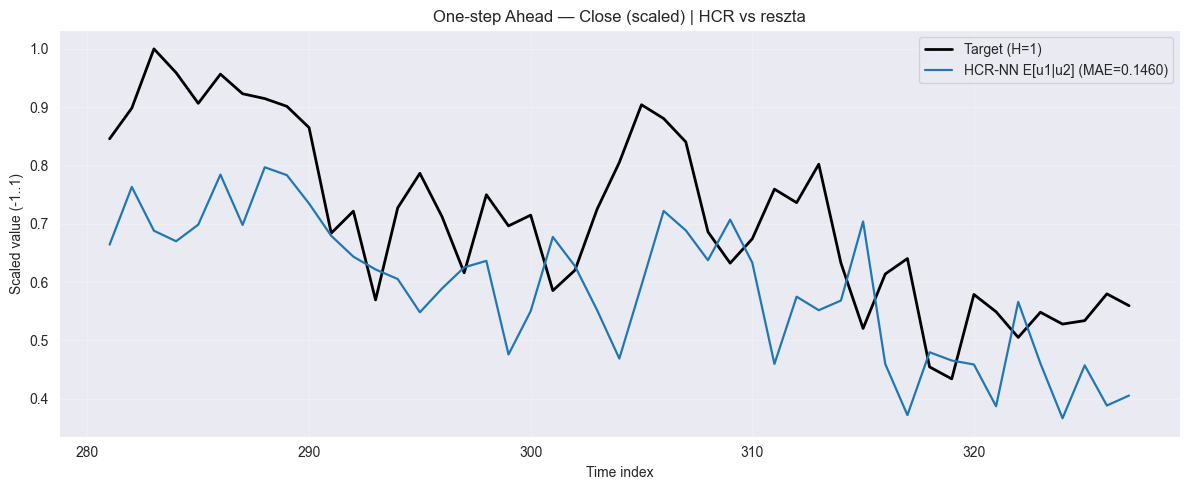

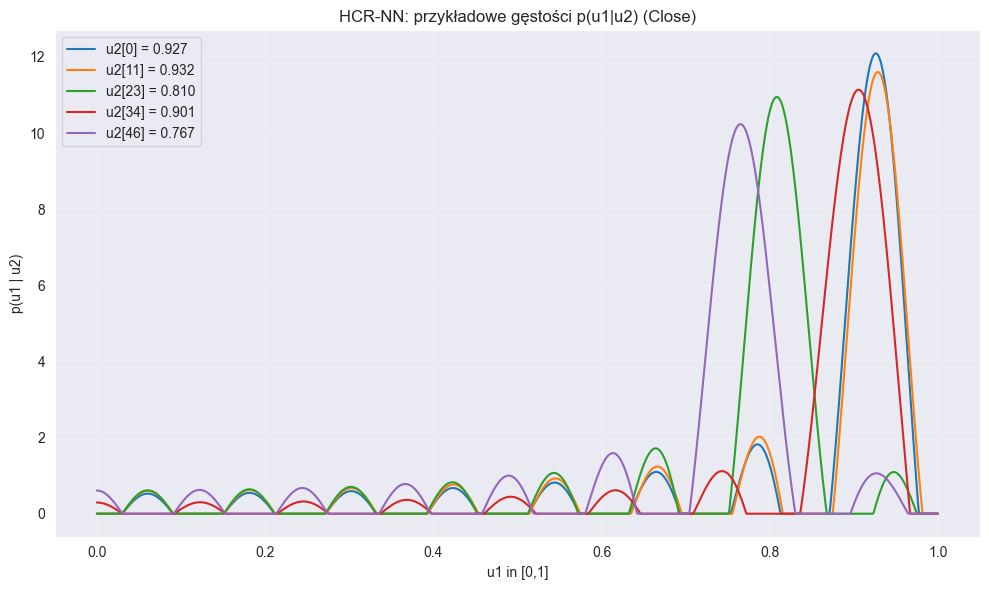

In [179]:
## HCR-NN: Conditional density p(u_{t+1} | u_t) dla 'Close' i prognoza (H=1)

import torch
import numpy as np


feature_name = 'Close'
f_idx = MH_FEATURES.index(feature_name)


def to_unit_interval(x_scaled):

    return np.clip((x_scaled + 1.0) * 0.5, 0.0, 1.0)


u2_train = to_unit_interval(X_train_mh[:, -1, f_idx])  # (N_train,)
u1_train = to_unit_interval(Y_train_mh[:, 0, f_idx])  # (N_train,)
u2_valid = to_unit_interval(X_valid_mh[:, -1, f_idx])
u1_valid = to_unit_interval(Y_valid_mh[:, 0, f_idx])
u2_test = to_unit_interval(X_test_mh[:, -1, f_idx])
u1_test = to_unit_interval(Y_test_mh[:, 0, f_idx])

u2_train_t = torch.as_tensor(u2_train, dtype=torch.float64)
u1_train_t = torch.as_tensor(u1_train, dtype=torch.float64)
u2_valid_t = torch.as_tensor(u2_valid, dtype=torch.float64)
u1_valid_t = torch.as_tensor(u1_valid, dtype=torch.float64)
u2_test_t = torch.as_tensor(u2_test, dtype=torch.float64)
u1_test_t = torch.as_tensor(u1_test, dtype=torch.float64)

from hcr_nn.models import build_hcr_cond2d


m = build_hcr_cond2d(degree=16, basis='cosine', grid_size=1024, dtype=torch.float64)
m.coeffs.requires_grad_(True)


def interp_density_at_samples(p_rows: torch.Tensor, grid: torch.Tensor, u1_samples: torch.Tensor):
    """
    p_rows: (B,G) – gęstość na siatce u1 dla każdej próbki u2
    grid:   (G,)  – siatka u1 w [0,1]
    u1_samples: (B,) – punkty, gdzie próbkujemy gęstość
    Zwraca: (B,) – p(u1|u2) z interpolacji liniowej
    """

    idx_right = torch.searchsorted(grid, u1_samples, right=True).clamp(1, grid.numel() - 1)
    idx_left = idx_right - 1

    g_left = grid[idx_left]
    g_right = grid[idx_right]
    p_left = p_rows[torch.arange(p_rows.size(0)), idx_left]
    p_right = p_rows[torch.arange(p_rows.size(0)), idx_right]

    w = (u1_samples - g_left) / (g_right - g_left + 1e-12)
    return (1.0 - w) * p_left + w * p_right


# 4) Pętla treningowa: minimalizujemy -log p(u1|u2) + niewielki L2 na współczynnikach
opt = torch.optim.Adam([m.coeffs], lr=5e-2)
weight_decay = 1e-4
best_state = None
best_val = float('inf')


def eval_nll(u2_vec, u1_vec):
    with torch.no_grad():
        p = m._conditional_density(u2_vec)  # (B,G)
        p_at = interp_density_at_samples(p, m.u1_grid, u1_vec).clamp_min(1e-12)
        return float(-(p_at.log()).mean().item())


for epoch in range(1, 601):
    m.train()
    opt.zero_grad()

    p_train = m._conditional_density(u2_train_t)  # (N_train, G)
    p_at = interp_density_at_samples(p_train, m.u1_grid, u1_train_t).clamp_min(1e-12)
    nll = -(p_at.log()).mean()
    reg = weight_decay * (m.coeffs ** 2).mean()
    loss = nll + reg
    loss.backward()
    opt.step()

    if epoch % 25 == 0 or epoch == 1:
        val_nll = eval_nll(u2_valid_t, u1_valid_t)
        if val_nll < best_val - 1e-8:
            best_val = val_nll
            best_state = m.coeffs.detach().clone()
        print(f"[HCR] ep={epoch:4d}  trainNLL={float(nll):.6f}  valNLL={val_nll:.6f}  reg={float(reg):.6f}")


if best_state is not None:
    m.coeffs.data.copy_(best_state)



# 5) Wartość oczekiwana E[u1|u2] ~ ∫ u1 * p(u1|u2) du1 (licz. trapezami na siatce)
with torch.no_grad():
    p_test = m._conditional_density(u2_test_t)  # (N_test, G)
    u1_grid = m.u1_grid
    du = u1_grid[1:] - u1_grid[:-1]

    y_vals = p_test * u1_grid.unsqueeze(0)
    e_u1 = torch.trapz(y_vals, u1_grid, dim=1)

hcr_pred_u1_unit = e_u1.numpy()  # w [0,1]

hcr_pred_scaled = hcr_pred_u1_unit * 2.0 - 1.0


y_test_h1_scaled = Y_test_mh[:, 0, f_idx]

from sklearn.metrics import mean_absolute_error

mae_hcr = mean_absolute_error(y_test_h1_scaled, hcr_pred_scaled)
print(f"HCR-NN (E[u1|u2]) — MAE (scaled): {mae_hcr:.6f}")


n_train_old = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
x_axis = np.arange(n_train_old, n_train_old + y_test_h1_scaled.shape[0])

plt.figure(figsize=(12, 5))
plt.plot(x_axis, y_test_h1_scaled, label="Target (H=1)", linewidth=2.0, color='black')
plt.plot(x_axis, hcr_pred_scaled, label=f"HCR-NN E[u1|u2] (MAE={mae_hcr:.4f})", linewidth=1.6)


plt.title("One-step Ahead — Close (scaled) | HCR vs reszta")
plt.xlabel("Time index");
plt.ylabel("Scaled value (-1..1)")
plt.grid(alpha=0.25);
plt.legend(loc="best", frameon=True)
plt.tight_layout();
plt.show()



with torch.no_grad():
    idxs = np.linspace(0, len(u2_test_t) - 1, 5, dtype=int)
    u2_pick = u2_test_t[idxs]
    P = m._conditional_density(u2_pick)  # (5, G)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(idxs):
    plt.plot(u1_grid.numpy(), P[i].numpy(), label=f"u2[{idx}] = {u2_test_t[idx]:.3f}")
plt.xlabel("u1 in [0,1]");
plt.ylabel("p(u1 | u2)")
plt.title("HCR-NN: przykładowe gęstości p(u1|u2) (Close)")
plt.legend();
plt.grid(alpha=0.3);
plt.tight_layout();
plt.show()


In [143]:
from torch.utils.data import Dataset, DataLoader
import torch

class MultiHorizonDataset(Dataset):
    """
    x: (N, T, F)
    y: (N, H, F)
    """
    def __init__(self, x_np, y_np):
        x = torch.as_tensor(x_np, dtype=torch.float32)
        y = torch.as_tensor(y_np, dtype=torch.float32)
        assert x.ndim == 3 and y.ndim == 3, "Oczekuję x:(N,T,F), y:(N,H,F)"
        assert x.shape[0] == y.shape[0] and x.shape[2] == y.shape[2], "N i F muszą się zgadzać"
        self.x, self.y = x, y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def make_loaders_mh(Xtr, Ytr, Xva, Yva, Xte, Yte, bs=BATCH_SIZE, num_workers=0, pin_memory=False):
    tr_ds = MultiHorizonDataset(Xtr, Ytr)
    va_ds = MultiHorizonDataset(Xva, Yva)
    te_ds = MultiHorizonDataset(Xte, Yte)
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True,  num_workers=num_workers, pin_memory=pin_memory)
    va_dl = DataLoader(va_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    te_dl = DataLoader(te_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    return tr_dl, va_dl, te_dl

train_dl_mh, valid_dl_mh, test_dl_mh = make_loaders_mh(X_train_mh, Y_train_mh, X_valid_mh, Y_valid_mh, X_test_mh, Y_test_mh)

xb, yb = next(iter(train_dl_mh))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))  # (B, T, F), (B, H, F)


Batch shapes: (64, 32, 5) (64, 4, 5)


In [144]:
import torch.nn as nn
import torch

F = len(MH_FEATURES)
H = len(HORIZONS)

class LSTM_MH(nn.Module):
    """
    LSTM -> linear -> (B, H, F)
    """
    def __init__(self, in_features=F, hidden_size=128, num_layers=1, dropout=0.0, horizons=H):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, horizons * in_features)
        self.horizons = horizons
        self.in_features = in_features

    def forward(self, x):  # x: (B, T, F)
        _, (h, _) = self.lstm(x)         # h: (num_layers, B, hidden)
        h_last = h[-1]                    # (B, hidden)
        out = self.head(h_last)           # (B, H*F)
        out = out.view(-1, self.horizons, self.in_features)  # (B, H, F)
        return out


class AdaptiveStudent(nn.Module):
    """
    'Adaptacyjna EMA' z parametrami ucznia wyznaczanymi z okna wejściowego.
    - Uczy się `alpha` w (0,1) per FEATURE (i opcjonalnie zależne od kontekstu).
    - Generuje H prognoz rekurencyjnie: y_{t+h} = alpha * y_{t+h-1} + (1-alpha) * x_{t}
    gdzie x_t to wektor na końcu okna wejściowego (ostatni punkt).
    """
    def __init__(self, in_features=F, horizons=H, context_hidden=64):
        super().__init__()
        self.in_features = in_features
        self.horizons = horizons
        # mała sieć, która z ostatniego okna robi wektor alf
        self.phi = nn.Sequential(
            nn.Flatten(),                       # (B, T*F)
            nn.Linear(INPUT_LEN*in_features, context_hidden),
            nn.ReLU(),
            nn.Linear(context_hidden, in_features),
            nn.Sigmoid()                        # alpha w (0,1)
        )
        # waga miksu: czy używać bardziej "ostatniej obserwacji" czy "poprzedniej prognozy"
        # Nie jest konieczna, ale pomaga stabilizować.
        self.mix_gate = nn.Sequential(
            nn.Flatten(),
            nn.Linear(INPUT_LEN*in_features, in_features),
            nn.Sigmoid()
        )

    def forward(self, x):  # x: (B, T, F)
        B = x.size(0)
        last = x[:, -1, :]                   # (B, F) ostatni punkt z okna
        alpha = self.phi(x)                  # (B, F) adaptacyjne alfy
        gate  = self.mix_gate(x)             # (B, F) bramka miksująca

        preds = []
        y_prev = last
        for _ in range(self.horizons):
            # adaptacyjna ema: y_next = alpha * y_prev + (1-alpha) * last
            y_next = alpha * y_prev + (1 - alpha) * last
            # lekki mix z wejściem (można pominąć)
            y_next = gate * y_next + (1 - gate) * last
            preds.append(y_next)
            y_prev = y_next.detach()  # odpięcie BPTT w głąb horyzontu (stabilniej); usuń .detach() jeśli chcesz pełny BPTT
        y = torch.stack(preds, dim=1)         # (B, H, F)
        return y


In [145]:
def mse_mh(pred, target):
    # pred, target: (B, H, F)
    return ((pred - target)**2).mean()

@torch.no_grad()
def evaluate_mh(model, loader):
    model.eval()
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pb = model(xb)
        losses.append(mse_mh(pb, yb).item())
    return float(np.mean(losses))

def train_mh(model, train_loader, valid_loader, epochs=EPOCHS, lr=LR, patience=PATIENCE, verbose_every=10, save_path=None):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float('inf')
    bad = 0
    history = {'train': [], 'valid': []}

    model.to(DEVICE)

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pb = model(xb)
            loss = mse_mh(pb, yb)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        tr = float(np.mean(losses))
        va = evaluate_mh(model, valid_loader)
        history['train'].append(tr); history['valid'].append(va)

        improved = va < best_val - 1e-9
        if improved:
            best_val = va
            bad = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            bad += 1

        if ep % verbose_every == 0 or improved:
            print(f"[{ep:4d}] train={tr:.6f} | valid={va:.6f} | best={best_val:.6f}")

        if bad >= patience:
            print(f"Early stop (patience={patience}) @ epoch {ep}")
            break

    return history, best_val


In [146]:
lstm_mh = LSTM_MH(in_features=F, hidden_size=128, num_layers=1, dropout=0.0, horizons=H).to(DEVICE)
student  = AdaptiveStudent(in_features=F, horizons=H, context_hidden=64).to(DEVICE)

hist_student, best_student = train_mh(
    student, train_dl_mh, valid_dl_mh,
    epochs=EPOCHS, lr=LR, patience=PATIENCE,
    verbose_every=10, save_path="student_mh.pt"
)

hist_lstm, best_lstm = train_mh(
    lstm_mh, train_dl_mh, valid_dl_mh,
    epochs=EPOCHS, lr=LR, patience=PATIENCE,
    verbose_every=10, save_path="lstm_mh.pt"
)

print("Best valid: student:", best_student, " | lstm:", best_lstm)


[   1] train=0.422388 | valid=0.413770 | best=0.413770
[  10] train=0.427102 | valid=0.413770 | best=0.413770
[  20] train=0.421368 | valid=0.413770 | best=0.413770
[  30] train=0.420618 | valid=0.413770 | best=0.413770
[  40] train=0.429748 | valid=0.413770 | best=0.413770
Early stop (patience=40) @ epoch 41
[   1] train=0.340047 | valid=0.438910 | best=0.438910
[   5] train=0.247121 | valid=0.421029 | best=0.421029
[   6] train=0.240262 | valid=0.391492 | best=0.391492
[   7] train=0.233658 | valid=0.362925 | best=0.362925
[   8] train=0.230787 | valid=0.337006 | best=0.337006
[   9] train=0.227935 | valid=0.316396 | best=0.316396
[  10] train=0.228093 | valid=0.302317 | best=0.302317
[  11] train=0.223676 | valid=0.292349 | best=0.292349
[  12] train=0.225747 | valid=0.289788 | best=0.289788
[  13] train=0.223486 | valid=0.287847 | best=0.287847
[  19] train=0.222594 | valid=0.287801 | best=0.287801
[  20] train=0.221987 | valid=0.283735 | best=0.283735
[  30] train=0.217339 | valid

In [147]:
import numpy as np

def ema_forecast_batch(last_window, alpha, horizons=HORIZONS):
    """
    last_window: (B, T, F)
    alpha: float w (0,1)
    Zwraca: (B, H, F)
    """
    last = last_window[:, -1, :]        # (B, F)
    y_prev = last
    preds = []
    for _ in horizons:
        y_next = alpha * y_prev + (1 - alpha) * last
        preds.append(y_next)
        y_prev = y_next
    return torch.stack(preds, dim=1)

@torch.no_grad()
def evaluate_ema(loader, alpha=0.8):
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pb = ema_forecast_batch(xb, alpha, HORIZONS)
        losses.append(mse_mh(pb, yb).item())
    return float(np.mean(losses))

ema_val_loss = evaluate_ema(valid_dl_mh, alpha=0.8)
ema_test_loss = evaluate_ema(test_dl_mh, alpha=0.8)
print("EMA baseline | valid:", ema_val_loss, "| test:", ema_test_loss)


EMA baseline | valid: 0.41376975178718567 | test: 0.46434685587882996


In [148]:
@torch.no_grad()
def predict_mh(model, loader):
    model.eval()
    Ys, Ps = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        pb = model(xb)              # (B, H, F)
        Ps.append(pb.cpu())
        Ys.append(yb.cpu())
    Y = torch.cat(Ys, dim=0).numpy()
    P = torch.cat(Ps, dim=0).numpy()
    return Y, P

# Załaduj najlepsze wagi i licz metryki
lstm_mh.load_state_dict(torch.load("lstm_mh.pt", map_location=DEVICE))
student.load_state_dict(torch.load("student_mh.pt", map_location=DEVICE))

Y_test_np = Y_test_mh
Y_stud_np = predict_mh(student, test_dl_mh)[1]
Y_lstm_np = predict_mh(lstm_mh, test_dl_mh)[1]

# EMA
@torch.no_grad()
def predict_ema(loader, alpha=0.8):
    Ps = []
    for xb, _ in loader:
        xb = xb.to(DEVICE)
        pb = ema_forecast_batch(xb, alpha, HORIZONS)
        Ps.append(pb.cpu())
    P = torch.cat(Ps, dim=0).numpy()
    return P

Y_ema_np = predict_ema(test_dl_mh, alpha=0.8)

def mse_per_horizon(pred, target):   # (N, H, F)
    return ((pred - target)**2).mean(axis=(0,2))  # (H,) średnia po N i F

def mae_per_horizon(pred, target):
    return (np.abs(pred - target)).mean(axis=(0,2))

print("MSE per H (student):", mse_per_horizon(Y_stud_np, Y_test_np))
print("MSE per H (lstm)   :", mse_per_horizon(Y_lstm_np, Y_test_np))
print("MSE per H (ema)    :", mse_per_horizon(Y_ema_np,  Y_test_np))


MSE per H (student): [0.47137255 0.5267266  0.39060586 0.46868245]
MSE per H (lstm)   : [0.24475753 0.26424329 0.28689595 0.33948141]
MSE per H (ema)    : [0.47137255 0.5267266  0.39060587 0.46868245]


RMSE(mean) student: 0.11701600212627344
RMSE(mean) lstm   : 0.33984520986451205
RMSE(mean) ema    : 0.11701600382635365


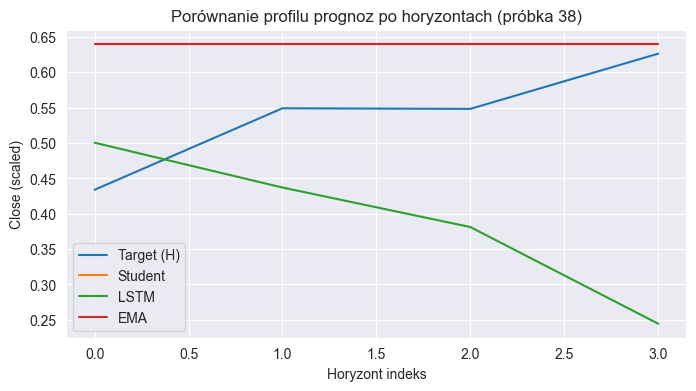

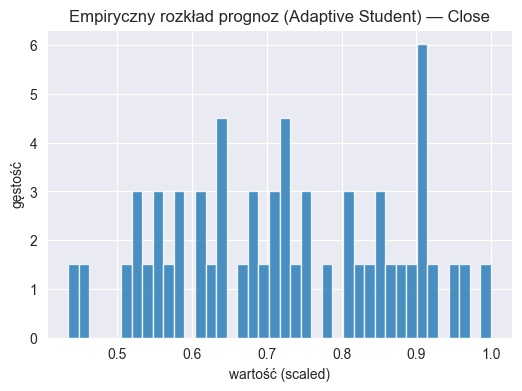

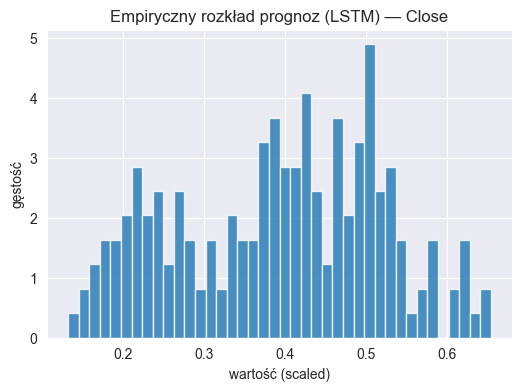

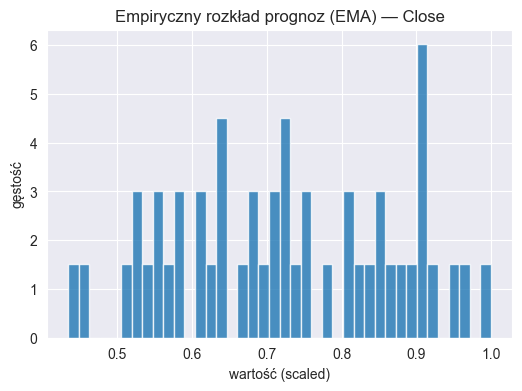

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

FEATURE_TO_PLOT = 'Close'
f_idx = MH_FEATURES.index(FEATURE_TO_PLOT)

def dist_stats(pred_mh, target_mh, f_idx):
    """
    pred_mh: (N, H, F), target_mh: (N, H, F)
    Zwraca ramkę: średnie z H, std po H, oraz kilka kwantyli po H (po N uśredniamy)
    """
    # statystyki liczymy po horyzontach (oś=1) i po N uśredniamy
    mean_pred = pred_mh[:,:,f_idx].mean(axis=1)            # (N,)
    std_pred  = pred_mh[:,:,f_idx].std(axis=1)             # (N,)
    q10 = np.quantile(pred_mh[:,:,f_idx], 0.10, axis=1)    # (N,)
    q50 = np.quantile(pred_mh[:,:,f_idx], 0.50, axis=1)
    q90 = np.quantile(pred_mh[:,:,f_idx], 0.90, axis=1)
    # target „następny” możemy wziąć np. h=1 (pierwszy horyzont) — to typowa referencja
    tgt = target_mh[:,0,f_idx]                              # (N,)
    df = pd.DataFrame({
        "target_h1": tgt,
        "pred_mean": mean_pred,
        "pred_std": std_pred,
        "q10": q10,
        "q50": q50,
        "q90": q90
    })
    return df

df_student = dist_stats(Y_stud_np, Y_test_np, f_idx)
df_lstm    = dist_stats(Y_lstm_np,  Y_test_np, f_idx)
df_ema     = dist_stats(Y_ema_np,   Y_test_np, f_idx)

def rmse(a, b): return float(np.sqrt(np.mean((a - b)**2)))
print("RMSE(mean) student:", rmse(df_student['pred_mean'].values, df_student['target_h1'].values))
print("RMSE(mean) lstm   :", rmse(df_lstm['pred_mean'].values,    df_lstm['target_h1'].values))
print("RMSE(mean) ema    :", rmse(df_ema['pred_mean'].values,     df_ema['target_h1'].values))

# Wykres: porównanie „próbki rozkładu” dla jednego przykładu z testu
idx = np.random.randint(0, Y_test_np.shape[0])  # wybierz losową próbkę
x_axis = np.arange(len(HORIZONS))

plt.figure(figsize=(8,4))
plt.plot(x_axis, Y_test_np[idx,:,f_idx], label="Target (H)")
plt.plot(x_axis, Y_stud_np[idx,:,f_idx], label="Student")
plt.plot(x_axis, Y_lstm_np[idx,:,f_idx], label="LSTM")
plt.plot(x_axis, Y_ema_np[idx,:,f_idx],  label="EMA")
plt.xlabel("Horyzont indeks")
plt.ylabel(f"{FEATURE_TO_PLOT} (scaled)")
plt.title(f"Porównanie profilu prognoz po horyzontach (próbka {idx})")
plt.legend()
plt.show()

# Wykres: „rozkład” (histogram) KILKU próbek po H dla danego modelu
def plot_empirical_distribution(P, label):
    vals = P[:, :, f_idx].reshape(-1)    # zbierz wszystkie horyzonty i próbki
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=40, alpha=0.8, density=True)
    plt.title(f"Empiryczny rozkład prognoz ({label}) — {FEATURE_TO_PLOT}")
    plt.xlabel("wartość (scaled)"); plt.ylabel("gęstość")
    plt.show()

plot_empirical_distribution(Y_stud_np, "Adaptive Student")
plot_empirical_distribution(Y_lstm_np, "LSTM")
plot_empirical_distribution(Y_ema_np,  "EMA")


In [150]:
def mse_per_hf(pred, target):  # (N,H,F)
    # MSE osobno dla par (h, f)
    return ((pred - target)**2).mean(axis=0)  # (H, F)

mse_student_hf = mse_per_hf(Y_stud_np, Y_test_np)
mse_lstm_hf    = mse_per_hf(Y_lstm_np,  Y_test_np)
mse_ema_hf     = mse_per_hf(Y_ema_np,   Y_test_np)

df_mse_student = pd.DataFrame(mse_student_hf, columns=MH_FEATURES, index=[f"H{h}" for h in HORIZONS])
df_mse_lstm    = pd.DataFrame(mse_lstm_hf,    columns=MH_FEATURES, index=[f"H{h}" for h in HORIZONS])
df_mse_ema     = pd.DataFrame(mse_ema_hf,     columns=MH_FEATURES, index=[f"H{h}" for h in HORIZONS])

print("MSE per (H,F) — Student")
display(df_mse_student.style.format("{:.6f}"))

print("MSE per (H,F) — LSTM")
display(df_mse_lstm.style.format("{:.6f}"))

print("MSE per (H,F) — EMA")
display(df_mse_ema.style.format("{:.6f}"))


MSE per (H,F) — Student


,Open,Close,High,Low,trade_sign
H1,0.014173,0.013693,0.013286,0.017839,2.297872
H3,0.018009,0.018534,0.018186,0.025713,2.553191
H5,0.018869,0.020389,0.018510,0.022920,1.872340
H10,0.030999,0.033173,0.032423,0.034052,2.212766


MSE per (H,F) — LSTM


,Open,Close,High,Low,trade_sign
H1,0.063681,0.047497,0.036434,0.074934,1.001242
H3,0.088400,0.083992,0.063586,0.102785,0.982453
H5,0.107152,0.101071,0.088199,0.149407,0.988650
H10,0.157569,0.187250,0.140142,0.194201,1.018245


MSE per (H,F) — EMA


,Open,Close,High,Low,trade_sign
H1,0.014173,0.013693,0.013286,0.017839,2.297872
H3,0.018009,0.018534,0.018186,0.025713,2.553191
H5,0.018869,0.020389,0.018510,0.022920,1.872340
H10,0.030999,0.033173,0.032423,0.034052,2.212766


In [151]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

def pick_horizon(Y, h_index: int):
    """
    Y: (N, H, F), zwraca (N, F) dla wybranego horyzontu.
    h_index = 0 oznacza pierwszy krok naprzód.
    """
    return Y[:, h_index, :]

def inverse_feature(arr_2d, feature_index, scaler):
    """
    arr_2d: (N, F) w skali scaler_mh (-1,1)
    Zwraca wektor (N,) dla jednej cechy w skali oryginalnej.
    """
    N, F = arr_2d.shape
    tmp = np.zeros((N, F))
    tmp[:] = scaler.min_ / (1 - (-1)) * 0  # placeholder; i tak nadpiszemy cechę
    tmp[:, feature_index] = arr_2d[:, feature_index]
    inv = scaler.inverse_transform(tmp)
    return inv[:, feature_index]

def mae_mape(pred, true, eps=1e-8):
    """
    MAE i MAPE z ochroną przed dzieleniem przez 0 (MAPE).
    pred, true: (N,) lub (N,F) (wtedy liczona po wszystkich elementach).
    """
    pred = np.asarray(pred); true = np.asarray(true)
    mae = mean_absolute_error(true.ravel(), pred.ravel())
    # MAPE: ochronimy się przed 0 dodając eps do mianownika
    denom = np.maximum(np.abs(true.ravel()), eps)
    mape = np.mean(np.abs((true.ravel() - pred.ravel()) / denom))
    return mae, mape


## Comparision new methods

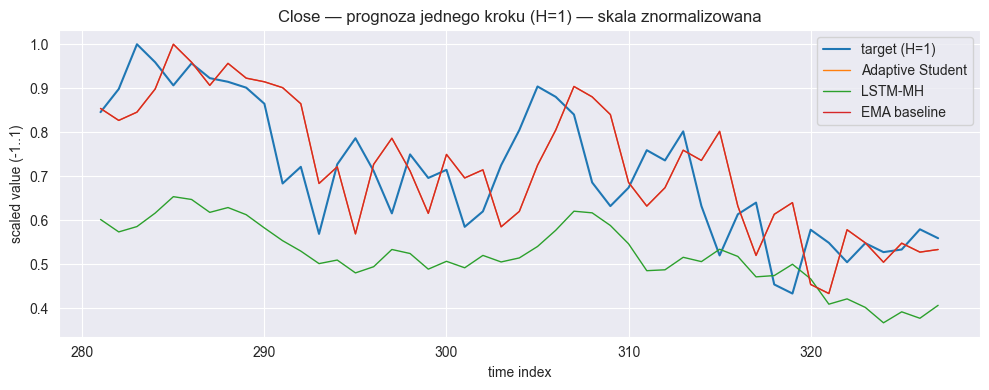

[Scaled] Student   | MAE=0.092968 | MAPE=0.141618
[Scaled] LSTM-MH   | MAE=0.194963 | MAPE=0.259841
[Scaled] EMA       | MAE=0.092968 | MAPE=0.141618


In [152]:
import matplotlib.pyplot as plt
import numpy as np

# Rysujemy np. 'Close' = idx=1 (Open=0, Close=1, High=2, Low=3, trade_sign=4)
feature_name = 'Close'
idx = MH_FEATURES.index(feature_name)

# Wybieramy pierwszy horyzont (H=1 => h_index=0)
y_test_h1   = pick_horizon(Y_test_np, 0)       # (N, F)
y_stud_h1   = pick_horizon(Y_stud_np, 0)
y_lstm_h1   = pick_horizon(Y_lstm_np, 0)
y_ema_h1    = pick_horizon(Y_ema_np,  0)

# Oś czasu (doklejony do końca trainu, jak w Twoim przykładzie):
n_train_old = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
x_axis = np.arange(n_train_old, n_train_old + y_test_h1.shape[0])

plt.figure(figsize=(10,4))
plt.plot(x_axis, y_test_h1[:, idx],  label='target (H=1)', lw=1.5)
plt.plot(x_axis, y_stud_h1[:, idx],  label='Adaptive Student', lw=1)
plt.plot(x_axis, y_lstm_h1[:, idx],  label='LSTM-MH', lw=1)
plt.plot(x_axis, y_ema_h1[:, idx],   label='EMA baseline', lw=1)
plt.title(f'{feature_name} — prognoza jednego kroku (H=1) — skala znormalizowana')
plt.xlabel('time index'); plt.ylabel('scaled value (-1..1)')
plt.legend()
plt.tight_layout()
plt.show()

# MAE/MAPE (w skali znormalizowanej)
for name, pred in [('Student', y_stud_h1), ('LSTM-MH', y_lstm_h1), ('EMA', y_ema_h1)]:
    mae, mape = mae_mape(pred[:, idx], y_test_h1[:, idx])
    print(f"[Scaled] {name:9s} | MAE={mae:.6f} | MAPE={mape:.6f}")


## Final Compariosn (yet without HCR-NN)

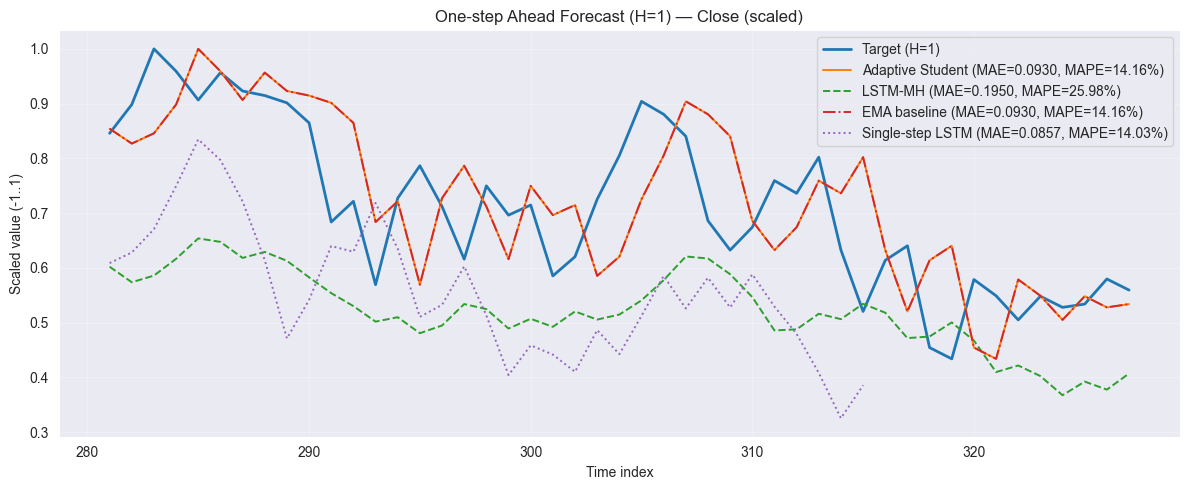

=== Scaled MAE/MAPE on H=1 — Close ===
Adaptive Student: MAE=0.092968, MAPE=0.141618
LSTM-MH        : MAE=0.194963, MAPE=0.259841
EMA baseline   : MAE=0.092968, MAPE=0.141618
Single-step LSTM: MAE=0.085743, MAPE=0.140346


In [153]:
# =======================
# Final Comparison Figure
# =======================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# ---- Config ----
feature_name = 'Close'  # zmień na dowolne z MH_FEATURES
f_idx = MH_FEATURES.index(feature_name)
h_index = 0             # H=1 => index 0
title = f"One-step Ahead Forecast (H=1) — {feature_name} (scaled)"

# ---- Helpers ----
def pick_horizon(Y, h_index: int):
    return Y[:, h_index, :]  # (N, F)

def mape_safe(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(np.asarray(y_true).ravel()), eps)
    return float(np.mean(np.abs((np.asarray(y_true).ravel() - np.asarray(y_pred).ravel()) / denom)))

# ---- Data: targets + predictions (scaled) ----
# Multi-horizon targets/preds
y_test_h1 = pick_horizon(Y_test_np, h_index)          # (N, F)
series = []  # (label, values_1d)

# Adaptive Student
y_stud_h1 = pick_horizon(Y_stud_np, h_index)
mae_s  = mean_absolute_error(y_test_h1[:, f_idx], y_stud_h1[:, f_idx])
mape_s = mape_safe(y_test_h1[:, f_idx], y_stud_h1[:, f_idx])
series.append((f"Adaptive Student (MAE={mae_s:.4f}, MAPE={mape_s:.2%})", y_stud_h1[:, f_idx]))

# LSTM-MH
y_lstm_h1 = pick_horizon(Y_lstm_np, h_index)
mae_l  = mean_absolute_error(y_test_h1[:, f_idx], y_lstm_h1[:, f_idx])
mape_l = mape_safe(y_test_h1[:, f_idx], y_lstm_h1[:, f_idx])
series.append((f"LSTM-MH (MAE={mae_l:.4f}, MAPE={mape_l:.2%})", y_lstm_h1[:, f_idx]))

# EMA baseline
y_ema_h1 = pick_horizon(Y_ema_np, h_index)
mae_e  = mean_absolute_error(y_test_h1[:, f_idx], y_ema_h1[:, f_idx])
mape_e = mape_safe(y_test_h1[:, f_idx], y_ema_h1[:, f_idx])
series.append((f"EMA baseline (MAE={mae_e:.4f}, MAPE={mape_e:.2%})", y_ema_h1[:, f_idx]))

# Single-step LSTM (old pipeline) — optional if present
have_single_step = ('y_pred_np' in globals()) and ('y_test_np' in globals()) and (y_test_np.ndim == 2)
if have_single_step:
    # idx 1 = Close w starej konwencji
    idx_old = 1
    mae_o  = mean_absolute_error(y_test_np[:, idx_old], y_pred_np[:, idx_old])
    mape_o = mape_safe(y_test_np[:, idx_old], y_pred_np[:, idx_old])
    series.append((f"Single-step LSTM (MAE={mae_o:.4f}, MAPE={mape_o:.2%})", y_pred_np[:, idx_old]))

# ---- X-axis aligned with your earlier plots (append after train) ----
n_train_old = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
# długość referencyjna = długość multi-horizon testu
N_test_len = y_test_h1.shape[0]
x_axis = np.arange(n_train_old, n_train_old + N_test_len)

# ---- Plot ----
plt.figure(figsize=(12, 5))
# target (scaled)
plt.plot(x_axis, y_test_h1[:, f_idx], label="Target (H=1)", linewidth=2.0)

# modele
linestyles = ['-', '--', '-.', ':']  # rotacja stylów
for i, (lbl, vals) in enumerate(series):
    # Jeśli to single-step i jego długość ≠ N_test_len, dopasuj (przytnij/paduj) – na wszelki wypadek:
    if len(vals) != N_test_len:
        L = min(len(vals), N_test_len)
        plt.plot(x_axis[:L], vals[:L], label=lbl, linestyle=linestyles[i % len(linestyles)], linewidth=1.4)
    else:
        plt.plot(x_axis, vals, label=lbl, linestyle=linestyles[i % len(linestyles)], linewidth=1.4)

plt.title(title)
plt.xlabel("Time index")
plt.ylabel("Scaled value (-1..1)")
plt.grid(alpha=0.25)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()

# ---- Print a compact metrics table as text (for reproducibility in logs) ----
print("=== Scaled MAE/MAPE on H=1 —", feature_name, "===")
print(f"Adaptive Student: MAE={mae_s:.6f}, MAPE={mape_s:.6f}")
print(f"LSTM-MH        : MAE={mae_l:.6f}, MAPE={mape_l:.6f}")
print(f"EMA baseline   : MAE={mae_e:.6f}, MAPE={mape_e:.6f}")
if have_single_step:
    print(f"Single-step LSTM: MAE={mae_o:.6f}, MAPE={mape_o:.6f}")


### New Jarek`s approach

In [154]:
# ==== CONFIG ====
feature_name = "Close"   # change to any name from MH_FEATURES
f_idx = MH_FEATURES.index(feature_name)
h_idx = 0                # H=1  (first horizon)

# ==== GROUND TRUTH (H=1) ====
y_train_h1 = Y_train_mh[:, h_idx, f_idx]   # (N_train,)
y_valid_h1 = Y_valid_mh[:, h_idx, f_idx]   # (N_valid,)
y_test_h1  = Y_test_mh[:,  h_idx, f_idx]   # (N_test,)

# ==== X windows (we only need them to build mean/width from inputs) ====
Xtr, Xva, Xte = X_train_mh, X_valid_mh, X_test_mh  # (N, T, F)

# ==== time axis aligned with your earlier plots ====
n_train_old = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
x_axis = np.arange(n_train_old, n_train_old + y_test_h1.shape[0])

# ==== metrics ====
from sklearn.metrics import mean_absolute_error
import numpy as np

def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    return float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))))

print(f"Scoring feature: {feature_name} (f_idx={f_idx}) | "
      f"shapes Xtr/Xva/Xte: {Xtr.shape}/{Xva.shape}/{Xte.shape} | "
      f"y_train/valid/test: {y_train_h1.shape}/{y_valid_h1.shape}/{y_test_h1.shape}")


Scoring feature: Close (f_idx=1) | shapes Xtr/Xva/Xte: (220, 32, 5)/(47, 32, 5)/(47, 32, 5) | y_train/valid/test: (220,)/(47,)/(47,)


In [155]:
def ema_last_value_forecast(X_win, f_idx: int, alpha: float) -> np.ndarray:
    """
    For each sample window (T steps), compute EMA over the selected feature
    and use the *last EMA value* as the forecast for the next step.
    X_win: (N, T, F) scaled inputs. Returns (N,) mean forecast in scaled units.
    """
    X = np.asarray(X_win)[:, :, f_idx]  # (N, T)
    out = np.empty(X.shape[0], dtype=np.float32)
    for i in range(X.shape[0]):
        ema = X[i, 0]
        for t in range(1, X.shape[1]):
            ema = alpha * X[i, t] + (1 - alpha) * ema
        out[i] = ema
    return out

# validate alpha on VALID to minimize MAE wrt y_valid_h1
alpha_grid = np.linspace(0.05, 0.95, 19)
best_alpha_val, best_mae_val = None, float("inf")
for a in alpha_grid:
    mu_val = ema_last_value_forecast(Xva, f_idx, alpha=a)
    mae = mean_absolute_error(y_valid_h1, mu_val)
    if mae < best_mae_val:
        best_mae_val, best_alpha_val = mae, a

print(f"[VALUE/mean via EMA] best alpha={best_alpha_val:.2f} (VALID MAE={best_mae_val:.6f})")

# build mean for all splits using best alpha
mu_train = ema_last_value_forecast(Xtr, f_idx, best_alpha_val)
mu_valid = ema_last_value_forecast(Xva, f_idx, best_alpha_val)
mu_test  = ema_last_value_forecast(Xte, f_idx, best_alpha_val)

print("mean shapes (train/valid/test):", mu_train.shape, mu_valid.shape, mu_test.shape)
print(f"[TEST] mean-only MAE={mean_absolute_error(y_test_h1, mu_test):.6f}  "
      f"MAPE={safe_mape(y_test_h1, mu_test):.6f}")


[VALUE/mean via EMA] best alpha=0.70 (VALID MAE=0.086032)
mean shapes (train/valid/test): (220,) (47,) (47,)
[TEST] mean-only MAE=0.087599  MAPE=0.132788


In [156]:
def window_width_ema(X_win, f_idx: int, beta: float) -> np.ndarray:
    """
    Causal EMA over |Δx_t| inside the window -> single width scalar for next step.
    Returns (N,) in scaled units. Ensures a small floor for numerical stability.
    """
    X = np.asarray(X_win)[:, :, f_idx]  # (N, T)
    out = np.empty(X.shape[0], dtype=np.float32)
    for i in range(X.shape[0]):
        diffs = np.abs(np.diff(X[i]))  # (T-1,)
        if diffs.size == 0:
            out[i] = 1e-4
            continue
        ema = diffs[0]
        for t in range(1, diffs.shape[0]):
            ema = beta * diffs[t] + (1 - beta) * ema
        out[i] = max(ema, 1e-4)
    return out

def gaussian_nll(y, mu, sigma):
    y = np.asarray(y); mu = np.asarray(mu)
    sigma = np.maximum(np.asarray(sigma), 1e-8)
    return float(np.mean(0.5*np.log(2*np.pi) + np.log(sigma) + 0.5*((y-mu)/sigma)**2))

# tune beta on VALID by minimizing Gaussian NLL (given fixed mu_valid from Cell 2)
beta_grid = np.linspace(0.05, 0.95, 19)
best_beta_val, best_nll_val = None, float("inf")
for b in beta_grid:
    sig_val = window_width_ema(Xva, f_idx, beta=b)
    nll = gaussian_nll(y_valid_h1, mu_valid, sig_val)
    if nll < best_nll_val:
        best_nll_val, best_beta_val = nll, b

print(f"[WIDTH/EMA] best beta={best_beta_val:.2f} (VALID Gaussian NLL={best_nll_val:.6f})")

# final sigma on all splits
sigma_train_ema = window_width_ema(Xtr, f_idx, best_beta_val)
sigma_valid_ema = window_width_ema(Xva, f_idx, best_beta_val)
sigma_test_ema  = window_width_ema(Xte, f_idx, best_beta_val)

print("sigma (EMA) shapes:", sigma_train_ema.shape, sigma_valid_ema.shape, sigma_test_ema.shape)
print(f"[TEST] EMA-width Gaussian NLL={gaussian_nll(y_test_h1, mu_test, sigma_test_ema):.6f}")


[WIDTH/EMA] best beta=0.10 (VALID Gaussian NLL=-0.119708)
sigma (EMA) shapes: (220,) (47,) (47,)
[TEST] EMA-width Gaussian NLL=-0.239772


In [157]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class WidthDataset(Dataset):
    """Returns (x_window, y_true (feature f), mu (feature f))"""
    def __init__(self, X, y_f, mu_f):
        self.X  = torch.as_tensor(X,   dtype=torch.float32)
        self.y  = torch.as_tensor(y_f, dtype=torch.float32)
        self.mu = torch.as_tensor(mu_f, dtype=torch.float32)
        assert self.X.shape[0] == self.y.shape[0] == self.mu.shape[0]
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i], self.mu[i]

train_w_dl = DataLoader(WidthDataset(Xtr, y_train_h1, mu_train), batch_size=64, shuffle=True)
valid_w_dl = DataLoader(WidthDataset(Xva, y_valid_h1, mu_valid), batch_size=64, shuffle=False)
test_w_dl  = DataLoader(WidthDataset(Xte, y_test_h1,  mu_test),  batch_size=64, shuffle=False)

class WidthLSTM(nn.Module):
    def __init__(self, in_features, hidden=64, layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_features, hidden_size=hidden,
                            num_layers=layers, batch_first=True)
        self.head = nn.Linear(hidden, 1)           # predicts log_sigma
        nn.init.constant_(self.head.bias, -2.3)    # ~ sigma ≈ 0.1 start
    def forward(self, x):                          # x: (B,T,F)
        _, (h, _) = self.lstm(x)
        z = h[-1]                                  # (B,H)
        log_sigma = self.head(z).squeeze(-1)       # (B,)
        return log_sigma

# FIX: robust Gaussian NLL in PyTorch (returns element-wise NLL so you can .mean())
import math
import torch

def gaussian_nll_torch(y: torch.Tensor,
                       mu: torch.Tensor,
                       log_sigma: torch.Tensor,
                       eps: float = 1e-8) -> torch.Tensor:
    """
    Element-wise negative log-likelihood under N(mu, sigma^2).
    Works on any device/dtype; numerically safe (sigma >= eps).

    y, mu:       shape (B,)
    log_sigma:   shape (B,)  -- the network outputs log(sigma)
    """
    # ensure common dtype/device
    y = y.to(dtype=torch.float32)
    mu = mu.to(dtype=torch.float32)
    log_sigma = log_sigma.to(dtype=torch.float32)

    # sigma >= eps to avoid -inf/NaN; keep log_sigma consistent after clamping
    sigma = torch.exp(log_sigma).clamp_min(eps)
    log_sigma = torch.log(sigma)

    # build constant on the same device
    log_2pi = torch.log(y.new_tensor(2.0 * math.pi))

    # per-sample NLL
    return 0.5 * (log_2pi + 2.0 * log_sigma) + 0.5 * ((y - mu) / sigma) ** 2


width_net = WidthLSTM(in_features=Xtr.shape[2], hidden=64, layers=1).to(DEVICE)
opt = torch.optim.Adam(width_net.parameters(), lr=1e-3, weight_decay=1e-4)

best_val, patience, bad = float("inf"), 60, 0
for ep in range(1, 801):
    width_net.train(); tr=[]
    for xb, yb, mub in train_w_dl:
        xb, yb, mub = xb.to(DEVICE), yb.to(DEVICE), mub.to(DEVICE)
        opt.zero_grad()
        log_sig = width_net(xb)
        nll = gaussian_nll_torch(yb, mub.detach(), log_sig).mean()
        nll.backward(); opt.step()
        tr.append(nll.item())
    width_net.eval(); va=[]
    with torch.no_grad():
        for xb, yb, mub in valid_w_dl:
            xb, yb, mub = xb.to(DEVICE), yb.to(DEVICE), mub.to(DEVICE)
            log_sig = width_net(xb)
            va.append(gaussian_nll_torch(yb, mub, log_sig).mean().item())
    v = float(np.mean(va))
    if v < best_val - 1e-9:
        best_val, bad = v, 0
        torch.save(width_net.state_dict(), "width_lstm_best.pt")
    else:
        bad += 1
    if ep % 25 == 0 or bad == 0:
        print(f"[WidthLSTM] ep={ep:4d}  train={np.mean(tr):.6f}  valid={v:.6f}  best={best_val:.6f}")
    if bad >= patience:
        print(f"[WidthLSTM] Early stop @ {ep}")
        break

width_net.load_state_dict(torch.load("width_lstm_best.pt", map_location=DEVICE))
width_net.eval()

# predict sigma on TEST
sig_lstm = []
with torch.no_grad():
    for xb, _, _ in test_w_dl:
        xb = xb.to(DEVICE)
        log_sig = width_net(xb)
        sig_lstm.append(torch.exp(log_sig).cpu().numpy())
sigma_test_lstm = np.concatenate(sig_lstm, axis=0)  # (N_test,)
sigma_test_lstm = np.maximum(sigma_test_lstm, 1e-6)
print("sigma_test_lstm shape:", sigma_test_lstm.shape)


[WidthLSTM] ep=   1  train=-0.794823  valid=-0.731526  best=-0.731526
[WidthLSTM] ep=   2  train=-0.841326  valid=-0.737780  best=-0.737780
[WidthLSTM] ep=   3  train=-0.834004  valid=-0.739601  best=-0.739601
[WidthLSTM] ep=  25  train=-0.908047  valid=-0.646450  best=-0.739601
[WidthLSTM] ep=  50  train=-0.956723  valid=-0.660167  best=-0.739601
[WidthLSTM] Early stop @ 63
sigma_test_lstm shape: (47,)


In [158]:
import math

def student_t_nll(y, mu, sigma, nu):
    y, mu, sigma = map(np.asarray, (y, mu, sigma))
    sigma = np.maximum(sigma, 1e-8)
    v = float(nu)
    c = math.lgamma((v+1)/2) - math.lgamma(v/2) - 0.5*math.log(v*math.pi) - np.log(sigma)
    z = 1.0 + ((y - mu)**2) / (v * sigma**2)
    ll = c - ((v+1)/2)*np.log(z)
    return float(-np.mean(ll))  # NLL

# choose ν for EMA-width and LSTM-width on VALID
nu_grid = (3,5,7,10,15,30,60)
best_ema = min(((nu, student_t_nll(y_valid_h1, mu_valid, sigma_valid_ema, nu)) for nu in nu_grid), key=lambda x:x[1])
# we need sigma_valid_lstm as well:
sig_lstm_val = []
with torch.no_grad():
    for xb, _, _ in valid_w_dl:
        xb = xb.to(DEVICE)
        sig_lstm_val.append(torch.exp(width_net(xb)).cpu().numpy())
sigma_valid_lstm = np.maximum(np.concatenate(sig_lstm_val, 0), 1e-8)
best_lstm = min(((nu, student_t_nll(y_valid_h1, mu_valid, sigma_valid_lstm, nu)) for nu in nu_grid), key=lambda x:x[1])

nu_ema, nll_val_ema = best_ema
nu_lstm, nll_val_lstm = best_lstm
print(f"[Student-t ν] EMA-width: ν={nu_ema}, valid NLL={nll_val_ema:.6f} | "
      f"LSTM-width: ν={nu_lstm}, valid NLL={nll_val_lstm:.6f}")


[Student-t ν] EMA-width: ν=3, valid NLL=-0.688702 | LSTM-width: ν=15, valid NLL=-0.746470


In [159]:
# deterministic mean metrics
mae_mu  = mean_absolute_error(y_test_h1, mu_test)
mape_mu = safe_mape(y_test_h1, mu_test)

# probabilistic (Gaussian + Student-t) for both width variants
def gaussian_nll(y, mu, sigma):
    y = np.asarray(y); mu = np.asarray(mu); sigma = np.maximum(np.asarray(sigma), 1e-8)
    return float(np.mean(0.5*np.log(2*np.pi) + np.log(sigma) + 0.5*((y-mu)/sigma)**2))

nll_gauss_ema   = gaussian_nll(y_test_h1, mu_test, sigma_test_ema)
nll_gauss_lstm  = gaussian_nll(y_test_h1, mu_test, sigma_test_lstm)
nll_t_ema       = student_t_nll(y_test_h1, mu_test, sigma_test_ema,  nu_ema)
nll_t_lstm      = student_t_nll(y_test_h1, mu_test, sigma_test_lstm, nu_lstm)

print(f"[MEAN] EMA-mean  MAE={mae_mu:.6f}  MAPE={mape_mu:.6f}")
print(f"[WIDTH] EMA   -> Gaussian NLL={nll_gauss_ema:.6f} | Student-t NLL (ν={nu_ema})={nll_t_ema:.6f}")
print(f"[WIDTH] LSTM  -> Gaussian NLL={nll_gauss_lstm:.6f} | Student-t NLL (ν={nu_lstm})={nll_t_lstm:.6f}")


[MEAN] EMA-mean  MAE=0.087599  MAPE=0.132788
[WIDTH] EMA   -> Gaussian NLL=-0.239772 | Student-t NLL (ν=3)=-0.659950
[WIDTH] LSTM  -> Gaussian NLL=-0.763699 | Student-t NLL (ν=15)=-0.750000


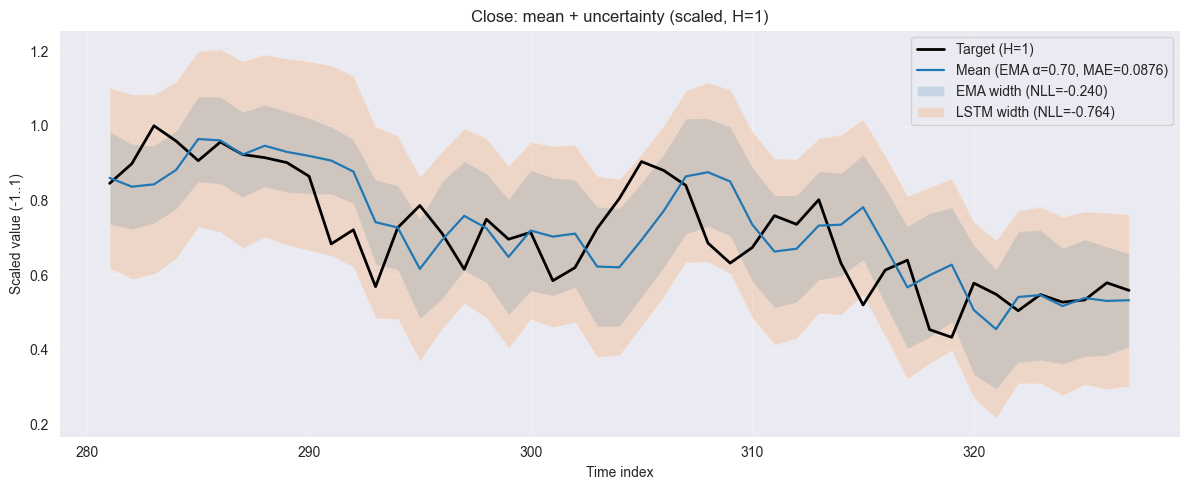

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(x_axis, y_test_h1, label="Target (H=1)", linewidth=2.0, color="black")
plt.plot(x_axis, mu_test,   label=f"Mean (EMA α={best_alpha_val:.2f}, MAE={mae_mu:.4f})", linewidth=1.6)

plt.fill_between(x_axis, mu_test - 2*sigma_test_ema,  mu_test + 2*sigma_test_ema,
                 alpha=0.18, label=f"EMA width (NLL={nll_gauss_ema:.3f})")
plt.fill_between(x_axis, mu_test - 2*sigma_test_lstm, mu_test + 2*sigma_test_lstm,
                 alpha=0.18, label=f"LSTM width (NLL={nll_gauss_lstm:.3f})")

plt.title(f"{feature_name}: mean + uncertainty (scaled, H=1)")
plt.xlabel("Time index"); plt.ylabel("Scaled value (-1..1)")
plt.grid(alpha=0.25); plt.legend(loc="best", frameon=True)
plt.tight_layout(); plt.show()


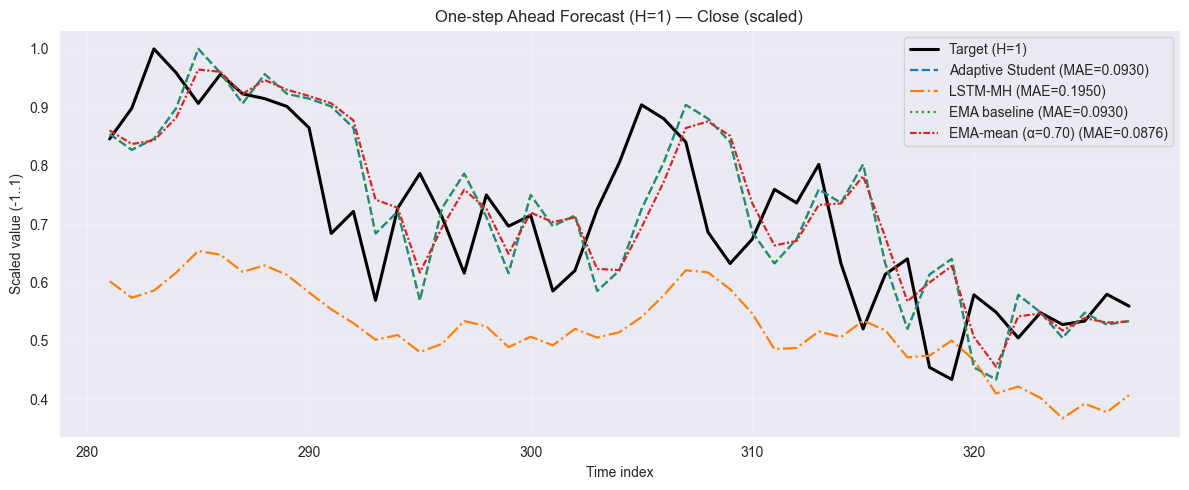

In [161]:
import matplotlib.pyplot as plt

series = [("TARGET", y_test_h1, None)]
def add_if_present(label, arr):
    if label is None or arr is None:
        return
    a = np.asarray(arr)
    if a.ndim != 1 or a.shape[0] != y_test_h1.shape[0]:
        return
    series.append((label, a, mean_absolute_error(y_test_h1, a)))

# Try to use your existing test predictions (if defined in the notebook)
add_if_present("Adaptive Student", globals().get("y_stud_h1", None)[:, f_idx] if "y_stud_h1" in globals() else None)
add_if_present("LSTM-MH",          globals().get("y_lstm_h1", None)[:, f_idx] if "y_lstm_h1" in globals() else None)
add_if_present("EMA baseline",     globals().get("y_ema_h1",  None)[:, f_idx] if "y_ema_h1"  in globals() else None)

# Optional: single-step LSTM from your old pipeline (2D arrays y_test_np/y_pred_np)
have_single = ('y_pred_np' in globals()) and ('y_test_np' in globals()) and (y_test_np.ndim==2)
if have_single:
    add_if_present("Single-step LSTM", y_pred_np[:, 1])  # idx=1 -> Close in old pipeline

# Our mean from Cell 2:
add_if_present(f"EMA-mean (α={best_alpha_val:.2f})", mu_test)

# plot
plt.figure(figsize=(12,5))
plt.plot(x_axis, series[0][1], label="Target (H=1)", linewidth=2.2, color="black")

linestyles = ['--','-.',':',(0,(3,1,1,1)),'-']
for i,(lbl, vals, mae) in enumerate(series[1:], start=1):
    tag = f"{lbl}" if mae is None else f"{lbl} (MAE={mae:.4f})"
    plt.plot(x_axis, vals, label=tag, linestyle=linestyles[(i-1) % len(linestyles)], linewidth=1.6)

plt.title(f"One-step Ahead Forecast (H=1) — {feature_name} (scaled)")
plt.xlabel("Time index"); plt.ylabel("Scaled value (-1..1)")
plt.grid(alpha=0.25); plt.legend(loc="best", frameon=True)
plt.tight_layout(); plt.show()


In [162]:
# ===========================================
# Unified summary table: all methods
# MAE / MAPE / MSE + NLL (Gauss/Student-t)
# ===========================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# --- Helpers ---
def mape_safe(y_true, y_pred, eps=1e-8):
    yt = np.asarray(y_true).ravel()
    yp = np.asarray(y_pred).ravel()
    return float(np.mean(np.abs((yt - yp) / np.maximum(np.abs(yt), eps))))

def gaussian_nll(y, mu, sigma, eps=1e-8):
    y = np.asarray(y)
    mu = np.asarray(mu)
    sigma = np.maximum(np.asarray(sigma), eps)
    return float(np.mean(0.5*np.log(2*np.pi) + np.log(sigma) + 0.5*((y-mu)/sigma)**2))

def student_t_nll(y, mu, sigma, nu, eps=1e-8):
    y = np.asarray(y)
    mu = np.asarray(mu)
    sigma = np.maximum(np.asarray(sigma), eps)
    v = float(nu)
    c = (math.lgamma((v+1)/2) - math.lgamma(v/2)
         - 0.5*np.log(v*np.pi) - np.log(sigma))
    z = 1.0 + ((y - mu)**2) / (v * sigma**2)
    ll = c - ((v+1)/2)*np.log(z)
    return float(-np.mean(ll))

# --- Targets (H=1, selected feature) ---
feature_name = 'Close'
f_idx = MH_FEATURES.index(feature_name)
h_index = 0
y_true = Y_test_mh[:, h_index, f_idx] if 'Y_test_mh' in globals() else y_test_h1

rows = []

# -------- Deterministic methods --------
if 'y_stud_h1' in globals():
    y_pred = y_stud_h1[:, f_idx]
    rows.append([
        "Adaptive Student", "—",
        mean_absolute_error(y_true, y_pred),
        mape_safe(y_true, y_pred),
        mean_squared_error(y_true, y_pred),
        np.nan, np.nan
    ])

if 'y_lstm_h1' in globals():
    y_pred = y_lstm_h1[:, f_idx]
    rows.append([
        "LSTM-MH", "—",
        mean_absolute_error(y_true, y_pred),
        mape_safe(y_true, y_pred),
        mean_squared_error(y_true, y_pred),
        np.nan, np.nan
    ])

if 'y_ema_h1' in globals():
    y_pred = y_ema_h1[:, f_idx]
    rows.append([
        "EMA baseline", "—",
        mean_absolute_error(y_true, y_pred),
        mape_safe(y_true, y_pred),
        mean_squared_error(y_true, y_pred),
        np.nan, np.nan
    ])

if ('y_pred_np' in globals()) and ('y_test_np' in globals()) and (y_test_np.ndim == 2):
    idx_old = 1  # Close in the old pipeline
    y_pred = y_pred_np[:, idx_old]
    y_targ = y_test_np[:, idx_old]
    rows.append([
        "Single-step LSTM", "—",
        mean_absolute_error(y_targ, y_pred),
        mape_safe(y_targ, y_pred),
        mean_squared_error(y_targ, y_pred),
        np.nan, np.nan
    ])

# -------- Probabilistic variants --------
if all(v in globals() for v in ['mu_test', 'sigma_test_ema']):
    mae_mu  = mean_absolute_error(y_true, mu_test)
    mape_mu = mape_safe(y_true, mu_test)
    mse_mu  = mean_squared_error(y_true, mu_test)
    nll_g = gaussian_nll(y_true, mu_test, sigma_test_ema)
    nll_t = student_t_nll(y_true, mu_test, sigma_test_ema, nu_ema) if 'nu_ema' in globals() else np.nan
    alpha_str = f"{best_alpha_val:.2f}" if 'best_alpha_val' in globals() else "?"
    beta_str  = f"{best_beta_val:.2f}"  if 'best_beta_val'  in globals() else "?"
    rows.append([
        f"EMA-mean (α={alpha_str}) + EMA-width (β={beta_str})",
        "Gaussian", mae_mu, mape_mu, mse_mu, nll_g, nll_t
    ])

if all(v in globals() for v in ['mu_test', 'sigma_test_lstm']):
    mae_mu  = mean_absolute_error(y_true, mu_test)
    mape_mu = mape_safe(y_true, mu_test)
    mse_mu  = mean_squared_error(y_true, mu_test)
    nll_g = gaussian_nll(y_true, mu_test, sigma_test_lstm)
    nll_t = student_t_nll(y_true, mu_test, sigma_test_lstm, nu_lstm) if 'nu_lstm' in globals() else np.nan
    alpha_str = f"{best_alpha_val:.2f}" if 'best_alpha_val' in globals() else "?"
    rows.append([
        f"EMA-mean (α={alpha_str}) + LSTM-width",
        "Gaussian", mae_mu, mape_mu, mse_mu, nll_g, nll_t
    ])
    
# --- Final DataFrame ---
df_all = pd.DataFrame(
    rows,
    columns=["Model", "Likelihood", "MAE (L1)", "MAPE", "MSE (L2)", "NLL (Gauss)", "NLL (Student-t)"]
)
display(df_all.style.format({
    "MAE (L1)":"{:.6f}", "MAPE":"{:.6f}", "MSE (L2)":"{:.6f}",
    "NLL (Gauss)":"{:.6f}", "NLL (Student-t)":"{:.6f}"
}))


,Model,Likelihood,MAE (L1),MAPE,MSE (L2),NLL (Gauss),NLL (Student-t)
0,Adaptive Student,—,0.092968,0.141618,0.013693,nan,nan
1,LSTM-MH,—,0.194963,0.259841,0.047497,nan,nan
2,EMA baseline,—,0.092968,0.141618,0.013693,nan,nan
3,Single-step LSTM,—,0.085743,0.140346,0.010444,nan,nan
4,EMA-mean (α=0.70) + EMA-width (β=0.10),Gaussian,0.087599,0.132788,0.012621,-0.239772,-0.659950
5,EMA-mean (α=0.70) + LSTM-width,Gaussian,0.087599,0.132788,0.012621,-0.763699,-0.750000


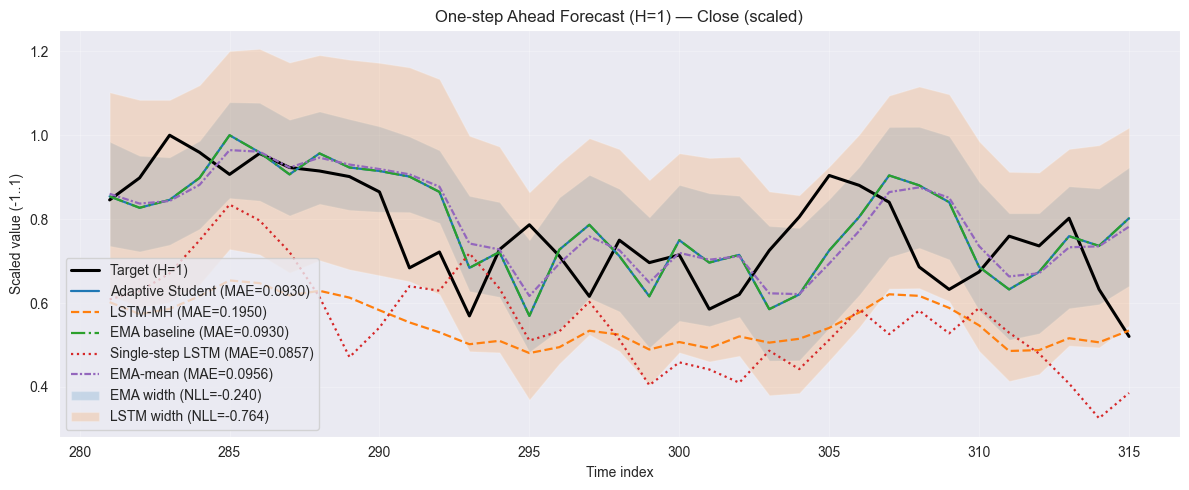

In [163]:
# ===========================================
# Final comparison figure (all series)
# + uncertainty bands where available
# ===========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# ---- Config ----
feature_name = 'Close'
f_idx = MH_FEATURES.index(feature_name)
h_index = 0
title = f"One-step Ahead Forecast (H=1) — {feature_name} (scaled)"

# ---- Target & x-axis ----
y_test_h1 = Y_test_mh[:, h_index, :] if 'Y_test_mh' in globals() else pick_horizon(Y_test_np, h_index)
y_true = y_test_h1[:, f_idx]
n_train_old = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
x_axis = np.arange(n_train_old, n_train_old + y_true.shape[0])

# ---- Build series (label, values) dynamically if present ----
series = []

if 'y_stud_h1' in globals():
    mae_s = mean_absolute_error(y_true, y_stud_h1[:, f_idx])
    series.append((f"Adaptive Student (MAE={mae_s:.4f})", y_stud_h1[:, f_idx]))

if 'y_lstm_h1' in globals():
    mae_l = mean_absolute_error(y_true, y_lstm_h1[:, f_idx])
    series.append((f"LSTM-MH (MAE={mae_l:.4f})", y_lstm_h1[:, f_idx]))

if 'y_ema_h1' in globals():
    mae_e = mean_absolute_error(y_true, y_ema_h1[:, f_idx])
    series.append((f"EMA baseline (MAE={mae_e:.4f})", y_ema_h1[:, f_idx]))

# Optional: old single-step LSTM
if ('y_pred_np' in globals()) and ('y_test_np' in globals()) and (y_test_np.ndim == 2):
    idx_old = 1
    mae_o = mean_absolute_error(y_test_np[:, idx_old], y_pred_np[:, idx_old])
    # If its length differs from MH test, crop to common min length (defensive)
    vals_old = y_pred_np[:, idx_old]
    L = min(len(vals_old), len(y_true))
    series.append((f"Single-step LSTM (MAE={mae_o:.4f})", vals_old[:L]))
    # also crop y_true/x_axis for consistent plotting lengths
    y_true_plot = y_true[:L]
    x_axis_plot = x_axis[:L]
else:
    y_true_plot = y_true
    x_axis_plot = x_axis

# Our mean (EMA-mean) always plotted if available (helps anchor uncertainty bands)
if 'mu_test' in globals():
    mae_mu = mean_absolute_error(y_true_plot, np.asarray(mu_test).reshape(-1)[:len(y_true_plot)])
    series.append((f"EMA-mean (MAE={mae_mu:.4f})", np.asarray(mu_test).reshape(-1)[:len(y_true_plot)]))

# ---- Plot ----
plt.figure(figsize=(12, 5))
plt.plot(x_axis_plot, y_true_plot, label="Target (H=1)", linewidth=2.2, color='black')

linestyles = ['-', '--', '-.', ':', (0,(3,1,1,1))]
for i, (lbl, vals) in enumerate(series):
    vals = np.asarray(vals).reshape(-1)[:len(x_axis_plot)]
    plt.plot(x_axis_plot, vals, label=lbl, linestyle=linestyles[i % len(linestyles)], linewidth=1.6)

# Uncertainty bands if available
# EMA-width
if all(v in globals() for v in ['mu_test', 'sigma_test_ema']):
    mu_plot = np.asarray(mu_test).reshape(-1)[:len(x_axis_plot)]
    sig_plot = np.asarray(sigma_test_ema).reshape(-1)[:len(x_axis_plot)]
    # If NLL already computed, show it; else compute here
    if 'nll_gauss_ema' in globals():
        label_band = f"EMA width (NLL={nll_gauss_ema:.3f})"
    else:
        from math import isnan
        _nll = gaussian_nll(y_true_plot, mu_plot, sig_plot)
        label_band = f"EMA width (NLL={_nll:.3f})"
    plt.fill_between(x_axis_plot, mu_plot - 2*sig_plot, mu_plot + 2*sig_plot, alpha=0.18, label=label_band)

# LSTM-width
if all(v in globals() for v in ['mu_test', 'sigma_test_lstm']):
    mu_plot = np.asarray(mu_test).reshape(-1)[:len(x_axis_plot)]
    sig_plot = np.asarray(sigma_test_lstm).reshape(-1)[:len(x_axis_plot)]
    if 'nll_gauss_lstm' in globals():
        label_band = f"LSTM width (NLL={nll_gauss_lstm:.3f})"
    else:
        _nll = gaussian_nll(y_true_plot, mu_plot, sig_plot)
        label_band = f"LSTM width (NLL={_nll:.3f})"
    plt.fill_between(x_axis_plot, mu_plot - 2*sig_plot, mu_plot + 2*sig_plot, alpha=0.18, label=label_band)

plt.title(title)
plt.xlabel("Time index"); plt.ylabel("Scaled value (-1..1)")
plt.grid(alpha=0.25); plt.legend(loc="best", frameon=True)
plt.tight_layout(); plt.show()


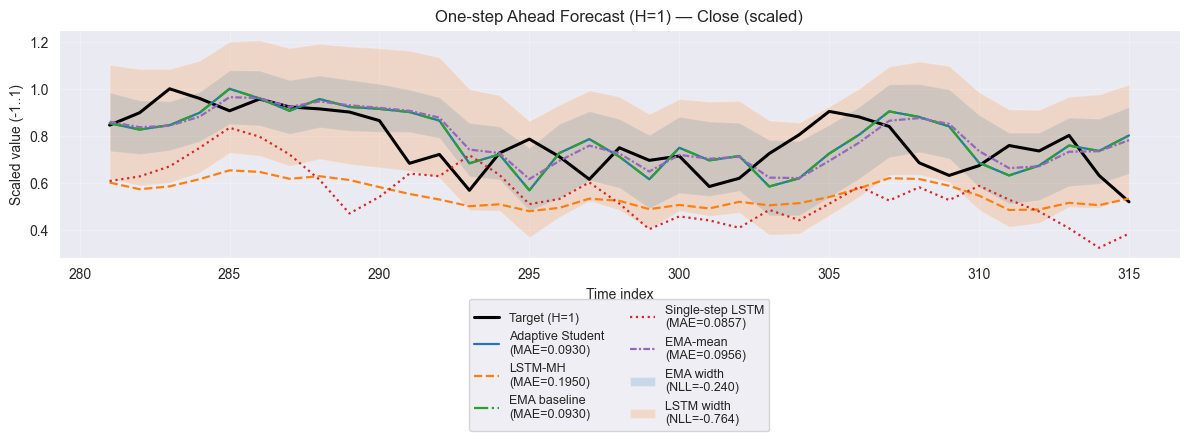

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# ---- Config ----
feature_name = 'Close'
f_idx = MH_FEATURES.index(feature_name)
h_index = 0
title = f"One-step Ahead Forecast (H=1) — {feature_name} (scaled)"

# ---- Target & x-axis ----
y_test_h1 = Y_test_mh[:, h_index, :] if 'Y_test_mh' in globals() else pick_horizon(Y_test_np, h_index)
y_true = y_test_h1[:, f_idx]
n_train_old = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
x_axis = np.arange(n_train_old, n_train_old + y_true.shape[0])

# ---- Build series ----
series = []

if 'y_stud_h1' in globals():
    mae_s = mean_absolute_error(y_true, y_stud_h1[:, f_idx])
    series.append((f"Adaptive Student\n(MAE={mae_s:.4f})", y_stud_h1[:, f_idx]))

if 'y_lstm_h1' in globals():
    mae_l = mean_absolute_error(y_true, y_lstm_h1[:, f_idx])
    series.append((f"LSTM-MH\n(MAE={mae_l:.4f})", y_lstm_h1[:, f_idx]))

if 'y_ema_h1' in globals():
    mae_e = mean_absolute_error(y_true, y_ema_h1[:, f_idx])
    series.append((f"EMA baseline\n(MAE={mae_e:.4f})", y_ema_h1[:, f_idx]))

# Optional: old single-step LSTM
if ('y_pred_np' in globals()) and ('y_test_np' in globals()) and (y_test_np.ndim == 2):
    idx_old = 1
    mae_o = mean_absolute_error(y_test_np[:, idx_old], y_pred_np[:, idx_old])
    vals_old = y_pred_np[:, idx_old]
    L = min(len(vals_old), len(y_true))
    series.append((f"Single-step LSTM\n(MAE={mae_o:.4f})", vals_old[:L]))
    y_true_plot = y_true[:L]
    x_axis_plot = x_axis[:L]
else:
    y_true_plot = y_true
    x_axis_plot = x_axis

# EMA-mean (anchor)
if 'mu_test' in globals():
    mae_mu = mean_absolute_error(y_true_plot, np.asarray(mu_test).reshape(-1)[:len(y_true_plot)])
    series.append((f"EMA-mean\n(MAE={mae_mu:.4f})", np.asarray(mu_test).reshape(-1)[:len(y_true_plot)]))

# ---- Plot ----
plt.figure(figsize=(12, 5))
plt.plot(x_axis_plot, y_true_plot, label="Target (H=1)", linewidth=2.2, color='black')

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
for i, (lbl, vals) in enumerate(series):
    vals = np.asarray(vals).reshape(-1)[:len(x_axis_plot)]
    plt.plot(x_axis_plot, vals, label=lbl, linestyle=linestyles[i % len(linestyles)], linewidth=1.6)

# Uncertainty bands
if all(v in globals() for v in ['mu_test', 'sigma_test_ema']):
    mu_plot = np.asarray(mu_test).reshape(-1)[:len(x_axis_plot)]
    sig_plot = np.asarray(sigma_test_ema).reshape(-1)[:len(x_axis_plot)]
    if 'nll_gauss_ema' in globals():
        label_band = f"EMA width\n(NLL={nll_gauss_ema:.3f})"
    else:
        _nll = gaussian_nll(y_true_plot, mu_plot, sig_plot)
        label_band = f"EMA width\n(NLL={_nll:.3f})"
    plt.fill_between(x_axis_plot, mu_plot - 2*sig_plot, mu_plot + 2*sig_plot, alpha=0.18, label=label_band)

if all(v in globals() for v in ['mu_test', 'sigma_test_lstm']):
    mu_plot = np.asarray(mu_test).reshape(-1)[:len(x_axis_plot)]
    sig_plot = np.asarray(sigma_test_lstm).reshape(-1)[:len(x_axis_plot)]
    if 'nll_gauss_lstm' in globals():
        label_band = f"LSTM width\n(NLL={nll_gauss_lstm:.3f})"
    else:
        _nll = gaussian_nll(y_true_plot, mu_plot, sig_plot)
        label_band = f"LSTM width\n(NLL={_nll:.3f})"
    plt.fill_between(x_axis_plot, mu_plot - 2*sig_plot, mu_plot + 2*sig_plot, alpha=0.18, label=label_band)

plt.title(title)
plt.xlabel("Time index")
plt.ylabel("Scaled value (-1..1)")
plt.grid(alpha=0.25)

# Legenda pod wykresem, 2 kolumny
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True, fontsize=9)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # rezerwujemy miejsce na legendę

# Save for Overleaf
plt.savefig("forecast_h1_close.png", dpi=300, bbox_inches="tight")
plt.show()


In [165]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Upewnij się, że df5 ma kolumny 'Date' (datetime) i 'Close'
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df5['Date'], df5['Close'], color='#008B8B', linewidth=2)

# Tytuły i opisy osi
ax.set_title("Ethereum Price for the Masked 2021", fontsize=16, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("ETH Price (USD)", fontsize=12)

# Formatowanie osi X
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))

# Siatka i wygląd
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)

# Dopasowanie układu i zapis
plt.tight_layout()
plt.savefig("eth_price_2021.png", dpi=300)
plt.close()


<h2>XAI Analysis</h2>

<h3>Shapley Additive Explanations</h3>

In [168]:
# =========================
# SHAP dla LSTM_MH i AdaptiveStudent
# =========================
import shap
import torch
import torch.nn as nn
import numpy as np
from types import MethodType

# ===== Przygotowanie modeli + urządzenie =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTM_MH().to(device).eval()
adaptive_model = AdaptiveStudent().to(device).eval()

# ===== Dane =====

def to_tensor_3d(x):
    if isinstance(x, np.ndarray):
        return torch.tensor(x, dtype=torch.float32, device=device)
    return x.to(device).float()

if 'X_test_mh' in globals():
    X_all = to_tensor_3d(X_test_mh)
elif 'X_mh' in globals():
    X_all = to_tensor_3d(X_mh)
else:
    X_all = torch.randn(100, INPUT_LEN, F, device=device)

BKG = int(min(64, max(4, X_all.shape[0] // 2)))
TEST = int(min(16, max(1, X_all.shape[0] - BKG)))
background   = X_all[:BKG]
test_samples = X_all[BKG:BKG+TEST]

# ===== Wrapper scalar-head (B,1) =====
class SHAPScalarHead(nn.Module):
    """Zwraca pojedynczy kanał (B,1) dla wybranego horyzontu i cechy."""
    def __init__(self, base: nn.Module, h_idx: int, f_idx: int):
        super().__init__()
        self.base = base
        self.h_idx = h_idx
        self.f_idx = f_idx
    def forward(self, x):
        y = self.base(x)                          # (B, H, F)
        y_sel = y[:, self.h_idx, self.f_idx]      # (B,)
        return y_sel.unsqueeze(1)                 # (B,1)


H_IDX = 0
F_IDX = 1 if F > 1 else 0

# ===== helper =====
def to_BTF(shap_out):
    """
    Normalizuje zwrot SHAP (lista/array) do (B, T, F).
    Obsługuje: list -> array, (1,B,T,F)->(B,T,F), (B,T)->(B,T,1).
    """
    arr = shap_out[0] if isinstance(shap_out, list) else shap_out
    arr = np.array(arr)


    if arr.ndim == 4 and arr.shape[0] == 1:
        arr = arr[0]

    arr = np.squeeze(arr)
    if arr.ndim == 2:
        arr = arr[..., None]

    assert arr.ndim == 3, f"Spodziewam się (B,T,F), mam {arr.shape}"
    return arr


wrapped_lstm = SHAPScalarHead(lstm_model, H_IDX, F_IDX).to(device)
explainer_lstm = shap.DeepExplainer(wrapped_lstm, background)
shap_values_lstm = explainer_lstm.shap_values(test_samples, check_additivity=False)
shap_values_lstm = to_BTF(shap_values_lstm)
print("LSTM SHAP shape (B,T,F):", shap_values_lstm.shape)

def _forward_no_detach(self, x):
    last = x[:, -1, :]
    alpha = self.phi(x)
    gate  = self.mix_gate(x)
    preds = []
    y_prev = last
    for _ in range(self.horizons):
        y_next = alpha * y_prev + (1 - alpha) * last
        y_next = gate * y_next + (1 - gate) * last
        preds.append(y_next)
        y_prev = y_next
    return torch.stack(preds, dim=1)

_adapt_forward_orig = adaptive_model.forward
adaptive_model.forward = MethodType(_forward_no_detach, adaptive_model)

try:
    wrapped_adapt = SHAPScalarHead(adaptive_model, H_IDX, F_IDX).to(device)
    explainer_adapt = shap.DeepExplainer(wrapped_adapt, background)
    shap_values_adapt = explainer_adapt.shap_values(test_samples, check_additivity=False)
    shap_values_adapt = to_BTF(shap_values_adapt)
    print("Adaptive SHAP shape (B,T,F):", shap_values_adapt.shape)
finally:
    adaptive_model.forward = _adapt_forward_orig


# Bezpieczny F_IDX (na wypadek F=1)
F_safe = shap_values_lstm.shape[-1]
if F_IDX >= F_safe:
    print(f"[WARN] F_IDX={F_IDX} poza zakresem (F={F_safe}). Ustawiam F_IDX={F_safe-1}.")
    F_IDX = F_safe - 1

# Średni wkład po czasie (dla wybranej cechy)
contrib_time_lstm   = shap_values_lstm[..., F_IDX].mean(axis=0)
contrib_time_adapt  = shap_values_adapt[..., F_IDX].mean(axis=0)

# Średni wkład po cechach (uśrednij po czasie i próbkach)
contrib_feat_lstm   = shap_values_lstm.mean(axis=1).mean(axis=0)
contrib_feat_adapt  = shap_values_adapt.mean(axis=1).mean(axis=0)

print("LSTM mean contrib over time (T,):",  contrib_time_lstm.shape)
print("ADAPT mean contrib over time (T,):", contrib_time_adapt.shape)
print("LSTM mean contrib over features (F,):",  contrib_feat_lstm.shape)
print("ADAPT mean contrib over features (F,):", contrib_feat_adapt.shape)



LSTM SHAP shape (B,T,F): (16, 32, 5)
Adaptive SHAP shape (B,T,F): (16, 32, 5)
LSTM mean contrib over time (T,): (32,)
ADAPT mean contrib over time (T,): (32,)
LSTM mean contrib over features (F,): (5,)
ADAPT mean contrib over features (F,): (5,)


<h3>Ceteris Paribus Profiling</h3>

In [169]:
def ceteris_paribus(model, x, feature_idx, time_idx=-1, grid=None, horizons_to_plot=None):
    """
    Compute Ceteris Paribus Profiles for one feature of a time-series model.
    
    Args:
        model: PyTorch model (nn.Module)
        x: single sample (T, F) as torch.Tensor
        feature_idx: which feature to vary (int)
        time_idx: which timestep to vary (default = last one)
        grid: np.array of values to evaluate (default = linspace over min/max of that feature)
        horizons_to_plot: list of horizons to plot (default = all)
    """
    model.eval()
    x = x.unsqueeze(0)  # add batch dim (1, T, F)

    # default grid: vary between min/max of this feature in the sample
    if grid is None:
        val = x[0, time_idx, feature_idx].item()
        grid = np.linspace(val*0.5, val*1.5, 30)  # ±50% around current value
    
    preds = []
    for g in grid:
        x_mod = x.clone()
        x_mod[0, time_idx, feature_idx] = g
        with torch.no_grad():
            y_hat = model(x_mod)  # (1, H, F)
        preds.append(y_hat.squeeze(0).numpy())  # (H, F)
    preds = np.array(preds)  # (grid_size, H, F)

    # Plot for each horizon (for the chosen feature)
    if horizons_to_plot is None:
        horizons_to_plot = range(preds.shape[1])

    plt.figure(figsize=(8,5))
    for h in horizons_to_plot:
        plt.plot(grid, preds[:, h, feature_idx], label=f"Horizon {h+1}")
    plt.xlabel(f"Feature {feature_idx} at time {time_idx}")
    plt.ylabel("Predicted value")
    plt.title("Ceteris Paribus Profile")
    plt.legend()
    plt.show()

    return grid, preds

CP profile for LSTM_MH:


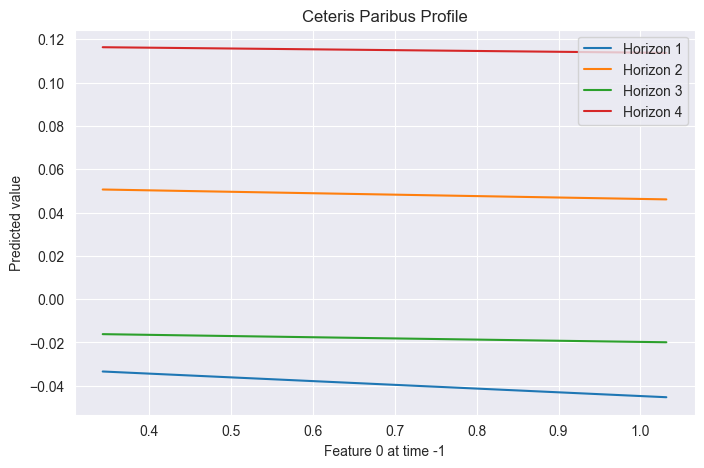

CP profile for AdaptiveStudent:


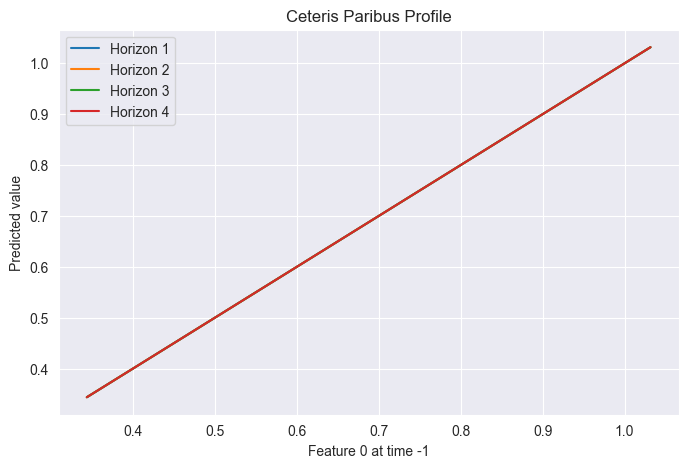

(array([0.34385923, 0.36757365, 0.39128808, 0.41500251, 0.43871694,
        0.46243137, 0.4861458 , 0.50986023, 0.53357466, 0.55728909,
        0.58100352, 0.60471795, 0.62843238, 0.65214681, 0.67586124,
        0.69957567, 0.7232901 , 0.74700452, 0.77071895, 0.79443338,
        0.81814781, 0.84186224, 0.86557667, 0.8892911 , 0.91300553,
        0.93671996, 0.96043439, 0.98414882, 1.00786325, 1.03157768]),
 array([[[0.34385923, 0.26607263, 0.88047934, 0.5117945 , 0.63145417],
         [0.34385923, 0.26607263, 0.88047934, 0.5117945 , 0.63145417],
         [0.34385923, 0.26607263, 0.88047934, 0.5117945 , 0.63145417],
         [0.34385923, 0.26607263, 0.88047934, 0.5117945 , 0.63145417]],
 
        [[0.36757362, 0.26607263, 0.88047934, 0.5117945 , 0.6314541 ],
         [0.36757362, 0.26607263, 0.88047934, 0.5117945 , 0.6314541 ],
         [0.36757362, 0.26607263, 0.88047934, 0.5117945 , 0.6314541 ],
         [0.36757362, 0.26607263, 0.88047934, 0.5117945 , 0.6314541 ]],
 
        [[0.3912

In [170]:
sample = torch.randn(INPUT_LEN, F)

# Example: Ceteris Paribus for feature 0 at last timestep
print("CP profile for LSTM_MH:")
ceteris_paribus(lstm_model, sample, feature_idx=0, time_idx=-1)

print("CP profile for AdaptiveStudent:")
ceteris_paribus(adaptive_model, sample, feature_idx=0, time_idx=-1)

<h3>Integrated Gradients</h3>

attr_lstm shape: (32, 32, 5) | delta_lstm: 4.802132025361061e-10
attr_adapt shape: (32, 32, 5) | delta_adapt: -9.313225746154785e-10


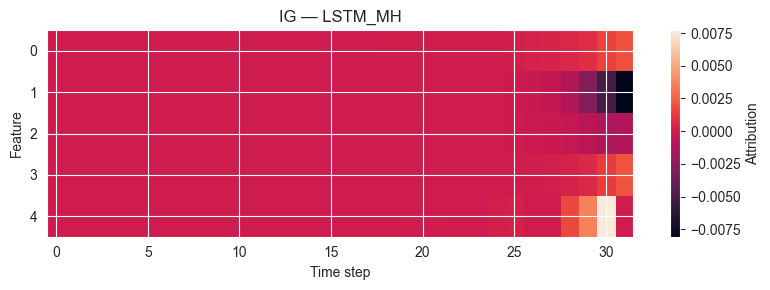

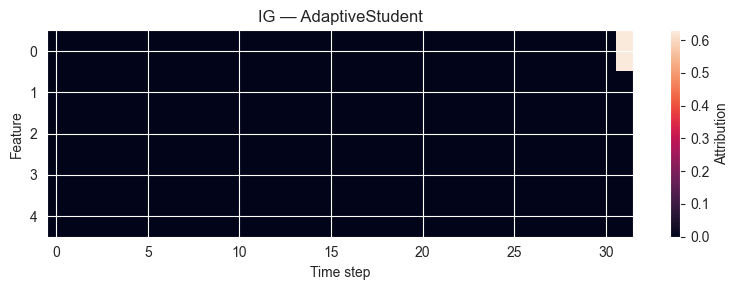

In [172]:
# --- Integrated Gradients for LSTM_MH and AdaptiveStudent ---
import torch
import torch.nn as nn
import numpy as np
from types import MethodType
from captum.attr import IntegratedGradients


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTM_MH().to(device).eval()
adaptive_model = AdaptiveStudent().to(device).eval()


def pick_X_batch_and_bg(B_batch: int = 32, B_bg: int = 128):

    if 'test_dl_mh' in globals():
        xb, _ = next(iter(test_dl_mh))
        X_batch = xb[:B_batch]
    elif 'X_test_mh' in globals():
        X_batch = torch.tensor(X_test_mh[:B_batch], dtype=torch.float32)
    elif 'X_mh' in globals():
        X_batch = torch.tensor(X_mh[-B_batch:], dtype=torch.float32)
    else:

        assert 'INPUT_LEN' in globals() and 'F' in globals(), "Zdefiniuj INPUT_LEN i F lub przekaż własne dane."
        X_batch = torch.randn(B_batch, INPUT_LEN, F, dtype=torch.float32)


    if 'train_dl_mh' in globals():
        X_bg_list = []
        seen = 0
        for xb, _ in train_dl_mh:
            X_bg_list.append(xb)
            seen += xb.size(0)
            if seen >= B_bg: break
        background = torch.cat(X_bg_list, dim=0) if X_bg_list else X_batch
    elif 'X_mh' in globals():
        background = torch.tensor(X_mh[:max(B_bg, 64)], dtype=torch.float32)
    else:
        background = X_batch.clone()

    return X_batch.to(device), background.to(device)

X_batch, background = pick_X_batch_and_bg(B_batch=32, B_bg=128)


class TargetSelector(nn.Module):
    def __init__(self, model: nn.Module, target_h: int, target_f: int):
        super().__init__()
        self.model = model
        self.target_h = target_h
        self.target_f = target_f
    def forward(self, x):
        y = self.model(x)
        return y[:, self.target_h, self.target_f]


def make_baseline(x: torch.Tensor, kind: str = "zeros", background: torch.Tensor | None = None):
    if kind == "zeros":
        return torch.zeros_like(x)
    if kind == "first":
        b = x[:, :1, :]
        return b.repeat(1, x.size(1), 1)
    if kind == "mean":
        assert background is not None, "`background` is required for kind='mean'"
        if background.ndim == 3:
            mu = background.mean(dim=(0,1))
        elif background.ndim == 2:
            mu = background.mean(dim=0)
        elif background.ndim == 1:
            mu = background
        else:
            raise ValueError("Unsupported background shape.")
        return mu.view(1,1,-1).repeat(x.size(0), x.size(1), 1)
    raise ValueError(f"Unknown baseline kind: {kind}")


def integrated_gradients_timeseries(
    model: nn.Module,
    x: torch.Tensor,
    target_h: int,
    target_f: int,
    baseline_kind: str = "first",
    background: torch.Tensor | None = None,
    steps: int = 100,
    device: str | torch.device = "cpu"
):
    model = model.to(device).eval()
    x = x.to(device).requires_grad_(True)

    wrapped = TargetSelector(model, target_h, target_f).to(device)
    ig = IntegratedGradients(wrapped)

    baselines = make_baseline(x, kind=baseline_kind,
                              background=background.to(device) if background is not None else None)

    attributions, delta = ig.attribute(
        inputs=x,
        baselines=baselines,
        n_steps=steps,
        return_convergence_delta=True
    )
    return attributions.detach(), delta.detach()



target_h = 0
target_f = 0
if 'F' in globals():
    target_f = min(target_f, F-1)  # safety


def _forward_no_detach(self, x):
    last = x[:, -1, :]
    alpha = self.phi(x)
    gate  = self.mix_gate(x)
    preds = []
    y_prev = last
    for _ in range(self.horizons):
        y_next = alpha * y_prev + (1 - alpha) * last
        y_next = gate * y_next + (1 - gate) * last
        preds.append(y_next)
        y_prev = y_next          # <-- brak .detach()
    return torch.stack(preds, dim=1)


attr_lstm, delta_lstm = integrated_gradients_timeseries(
    model=lstm_model,
    x=X_batch,
    target_h=target_h,
    target_f=target_f,
    baseline_kind="first",
    background=None,
    steps=100,
    device=device
)
print("attr_lstm shape:", tuple(attr_lstm.shape), "| delta_lstm:", delta_lstm.mean().item())

_adapt_forward_orig = adaptive_model.forward
adaptive_model.forward = MethodType(_forward_no_detach, adaptive_model)
try:
    attr_adapt, delta_adapt = integrated_gradients_timeseries(
        model=adaptive_model,
        x=X_batch,
        target_h=target_h,
        target_f=target_f,
        baseline_kind="first",
        background=None,
        steps=100,
        device=device
    )
finally:
    adaptive_model.forward = _adapt_forward_orig

print("attr_adapt shape:", tuple(attr_adapt.shape), "| delta_adapt:", delta_adapt.mean().item())

def plot_ig_heatmap(attributions: torch.Tensor, sample_idx: int = 0, title: str = ""):
    import matplotlib.pyplot as plt
    a = attributions[sample_idx].detach().cpu().numpy()  # (T,F)
    plt.figure(figsize=(8,3))
    plt.imshow(a.T, aspect="auto")
    plt.xlabel("Time step"); plt.ylabel("Feature")
    plt.title(title or "Integrated Gradients (time × feature)")
    plt.colorbar(label="Attribution"); plt.tight_layout(); plt.show()

# przykładowe heatmapy:
plot_ig_heatmap(attr_lstm,  sample_idx=0, title="IG — LSTM_MH")
plot_ig_heatmap(attr_adapt, sample_idx=0, title="IG — AdaptiveStudent")


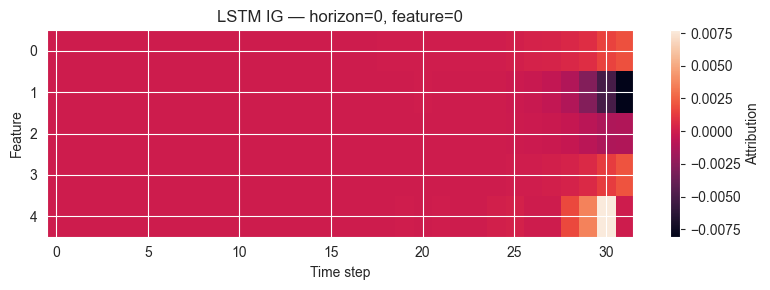

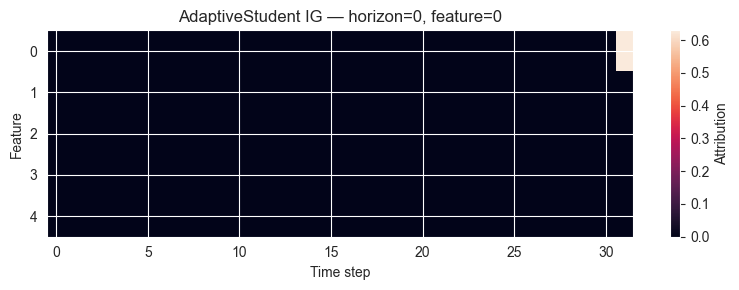

In [173]:
plot_ig_heatmap(attr_lstm, 0, f"LSTM IG — horizon={target_h}, feature={target_f}")
plot_ig_heatmap(attr_adapt, 0, f"AdaptiveStudent IG — horizon={target_h}, feature={target_f}")